In [1]:
!pip install ta
#!pip install fsspec # For Colab
#!pip install s3fs # For Colab
!pip install Mlflow

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
import os
import gc
import traceback
# import datatable as dt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
#import s3fs # For Colab
import mlflow
from mlflow.tracking import MlflowClient
from datetime import timedelta, datetime
#from google.colab import files
current_path = os.getcwd()

In [4]:
# Set graph style and font
sns.set()
# Change the axes' title and label size to 18 & 16 by default and default figure size, and make title bold
# Axes formatter limit will only display scientific notation if it's > 10^7 (or 10 million JPY) or < 10^-5
plt.rcParams.update({'axes.titleweight': 'bold','figure.figsize': (18,10),'axes.titlesize': 18,'axes.labelsize': 16, 
                     'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'font.family': 'serif', 
                     'axes.formatter.limits':'-5, 7'}) 

# Loading data

In [5]:
# For Kaggle use only
# directory_path = "/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/"
# BTC = pd.read_csv(directory_path + 'btcusd.csv')
# print(BTC.head())
# ETH = pd.read_csv(directory_path + 'ethusd.csv')
# print(ETH.head())
# LTC = pd.read_csv(directory_path + 'ltcusd.csv')
# print(LTC.head())

BTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/btcusd.csv"
BTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/btcusd.csv"
ETH_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/ethusd.csv"
ETH_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/ethusd.csv"
LTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/ltcusd.csv"
LTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/ltcusd.csv"

# Loading online from S3
%time BTC = pd.read_csv(BTC_USD_S3URI)
print(BTC.head())
%time ETH = pd.read_csv(ETH_USD_URL)
print(ETH.head())
%time LTC = pd.read_csv(LTC_USD_S3URI)
print(LTC.head())

CPU times: user 12.4 s, sys: 2.28 s, total: 14.7 s
Wall time: 2min 31s
            time    open   close    high     low     volume
0  1364774820000   93.25   93.30   93.30   93.25  93.300000
1  1364774880000  100.00  100.00  100.00  100.00  93.300000
2  1364774940000   93.30   93.30   93.30   93.30  33.676862
3  1364775060000   93.35   93.47   93.47   93.35  20.000000
4  1364775120000   93.47   93.47   93.47   93.47   2.021627
CPU times: user 2.66 s, sys: 1.59 s, total: 4.26 s
Wall time: 1min 5s
            time    open   close    high     low  volume
0  1457539440000  10.297  10.097  10.297  10.097    0.03
1  1457545740000  11.197  11.197  11.197  11.197    0.01
2  1457549760000  11.097  11.097  11.097  11.097    0.02
3  1457554560000  11.195  11.195  11.195  11.195    0.01
4  1457554860000  10.870  10.870  10.870  10.870    1.00
CPU times: user 6.99 s, sys: 1.27 s, total: 8.26 s
Wall time: 1min 17s
            time    open   close    high     low  volume
0  1368976980000  3.1491  3.1

In [6]:
# Convert to human timestamp
BTC['time'] = pd.to_datetime(BTC['time'], unit='ms')
ETH['time'] = pd.to_datetime(ETH['time'], unit='ms')
LTC['time'] = pd.to_datetime(LTC['time'], unit='ms')

In [7]:
BTC.describe(include='all')

/tmp/ipykernel_1090398/2862033533.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  BTC.describe(include='all')


,time,open,close,high,low,volume
count,3750538,3.750538e+06,3.750538e+06,3.750538e+06,3.750538e+06,3.750538e+06
unique,3750538,NaN,NaN,NaN,NaN,NaN
top,2013-04-01 00:07:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2013-04-01 00:07:00,NaN,NaN,NaN,NaN,NaN
last,2022-02-26 10:52:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.175632e+04,1.175634e+04,1.176248e+04,1.175017e+04,1.602312e+01
std,NaN,1.630193e+04,1.630199e+04,1.631052e+04,1.629339e+04,5.593794e+01
min,NaN,1.000000e-02,1.060000e+00,1.060000e+00,1.000000e-02,1.000000e-08
25%,NaN,6.734500e+02,6.734600e+02,6.738800e+02,6.730000e+02,5.093002e-01


In [8]:
ETH.describe(include='all')

/tmp/ipykernel_1090398/2040987820.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ETH.describe(include='all')


,time,open,close,high,low,volume
count,2533418,2.533418e+06,2.533418e+06,2.533418e+06,2.533418e+06,2.533418e+06
unique,2533418,NaN,NaN,NaN,NaN,NaN
top,2016-03-09 16:04:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2016-03-09 16:04:00,NaN,NaN,NaN,NaN,NaN
last,2022-02-26 10:52:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.951463e+02,8.951566e+02,8.957394e+02,8.945588e+02,1.240762e+02
std,NaN,1.175823e+03,1.175849e+03,1.176535e+03,1.175140e+03,4.592310e+02
min,NaN,5.890100e+00,5.861000e+00,5.890100e+00,5.861000e+00,1.000000e-08
25%,NaN,1.839600e+02,1.839600e+02,1.840100e+02,1.838800e+02,4.621515e+00


In [9]:
LTC.describe(include='all')

/tmp/ipykernel_1090398/2150209738.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  LTC.describe(include='all')


,time,open,close,high,low,volume
count,2368282,2.368282e+06,2.368282e+06,2.368282e+06,2.368282e+06,2.368282e+06
unique,2368282,NaN,NaN,NaN,NaN,NaN
top,2013-05-19 15:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2013-05-19 15:23:00,NaN,NaN,NaN,NaN,NaN
last,2022-02-26 10:51:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,9.296359e+01,9.296294e+01,9.304127e+01,9.288425e+01,1.466594e+02
std,NaN,7.336767e+01,7.336740e+01,7.345186e+01,7.328225e+01,5.098539e+02
min,NaN,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-08
25%,NaN,4.245600e+01,4.245500e+01,4.247800e+01,4.243500e+01,3.596867e+00


In [10]:
# Make copies of these df before doing further
BTC_copy = BTC.copy()
ETH_copy = ETH.copy()
LTC_copy = LTC.copy()

In [11]:
# Set time as index for plotting
BTC.set_index('time', inplace=True)
ETH.set_index('time', inplace=True)
LTC.set_index('time', inplace=True)
BTC

,open,close,high,low,volume
time,,,,,
2013-04-01 00:07:00,93.250000,93.30,93.30,93.250000,93.300000
2013-04-01 00:08:00,100.000000,100.00,100.00,100.000000,93.300000
2013-04-01 00:09:00,93.300000,93.30,93.30,93.300000,33.676862
2013-04-01 00:11:00,93.350000,93.47,93.47,93.350000,20.000000
2013-04-01 00:12:00,93.470000,93.47,93.47,93.470000,2.021627
...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.00,39012.00,39000.000000,0.168502
2022-02-26 10:49:00,39008.000000,38976.00,39008.00,38971.410904,1.341707
2022-02-26 10:50:00,38971.755285,39029.00,39029.00,38967.949394,6.989503


# EDA

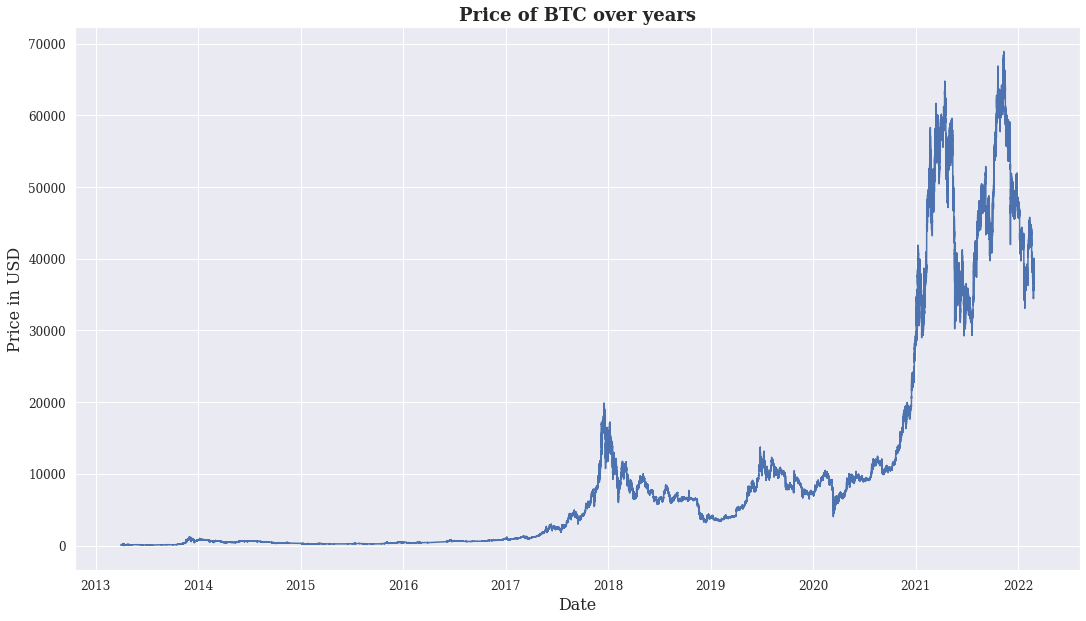

In [12]:
plt.plot(BTC.index, BTC.close)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price of BTC over years')
plt.show()

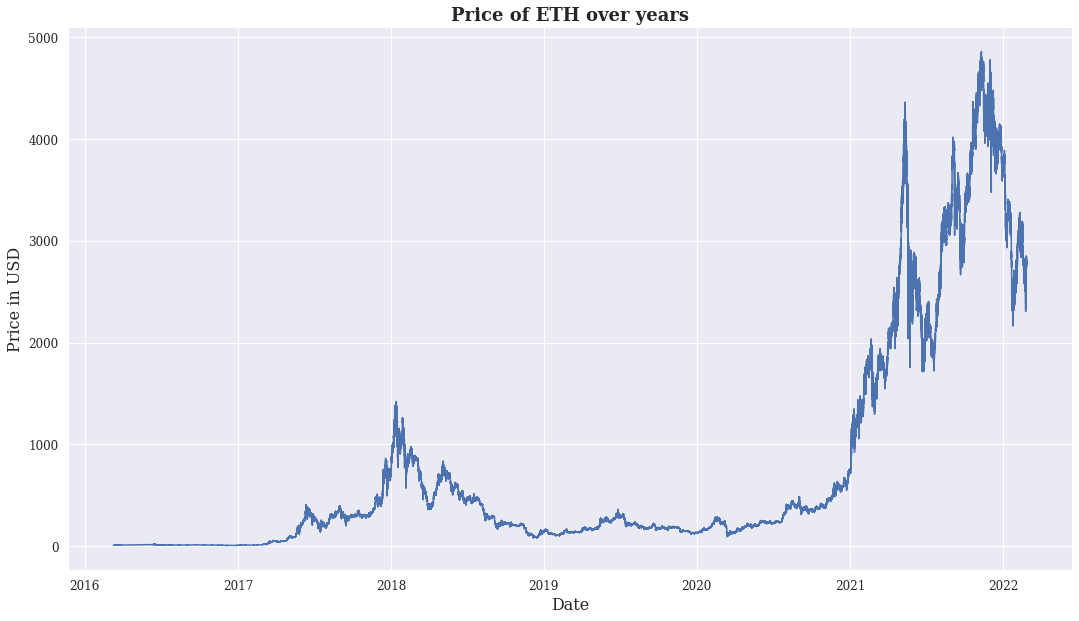

In [13]:
plt.plot(ETH.index, ETH.close)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price of ETH over years')
plt.show()

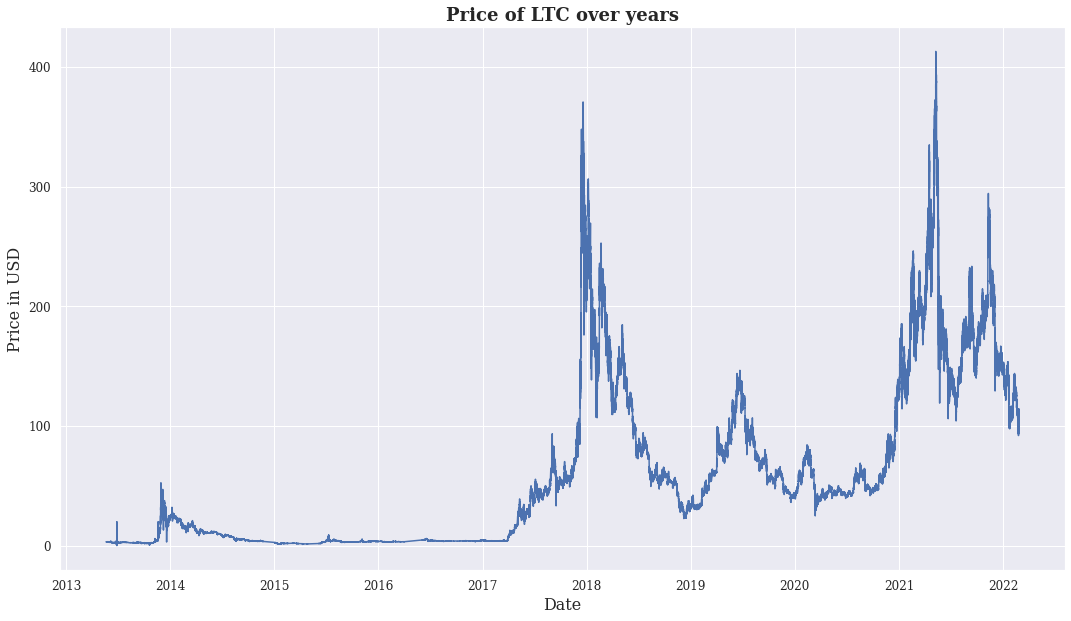

In [14]:
plt.plot(LTC.index, LTC.close)
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Price of LTC over years')
plt.show()

In [15]:
print(BTC.isnull().sum())
print(ETH.isnull().sum())
print(LTC.isnull().sum())

open      0
close     0
high      0
low       0
volume    0
dtype: int64
open      0
close     0
high      0
low       0
volume    0
dtype: int64
open      0
close     0
high      0
low       0
volume    0
dtype: int64


No null values at all, no need to drop any data

In [16]:
# Use only data from the last 2 years for modelling
BTC_2yr = BTC['2020-01-01':]
ETH_2yr = ETH['2020-01-01':]
LTC_2yr = LTC['2020-01-01':]
BTC_2yr

,open,close,high,low,volume
time,,,,,
2020-01-01 00:00:00,7208.200000,7200.000000,7208.200000,7200.000000,0.593130
2020-01-01 00:01:00,7200.000000,7200.000000,7200.000000,7200.000000,0.536795
2020-01-01 00:02:00,7200.000000,7200.038592,7200.038592,7200.000000,0.022248
2020-01-01 00:03:00,7200.000000,7200.000000,7200.000000,7200.000000,0.022585
2020-01-01 00:04:00,7200.000000,7199.000000,7200.000000,7199.000000,0.465026
...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.000000,39012.000000,39000.000000,0.168502
2022-02-26 10:49:00,39008.000000,38976.000000,39008.000000,38971.410904,1.341707
2022-02-26 10:50:00,38971.755285,39029.000000,39029.000000,38967.949394,6.989503


# Feature engineering

In [17]:
def upper_shadow(df): return df['high'] - np.maximum(df['close'], df['open'])
def lower_shadow(df): return np.minimum(df['close'], df['open']) - df['low']

def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['high'] - df_feat['low']
    df_feat['upper_shadow'] = upper_shadow(df_feat)
    df_feat['lower_shadow'] = lower_shadow(df_feat)
    df_feat['close-open'] = df_feat['close'] - df_feat['open']
    df_feat['SMA_7'] = df_feat.iloc[:,1].rolling(window=7).mean()
    df_feat['SMA_14'] = df_feat.iloc[:,1].rolling(window=14).mean()
    df_feat['SMA_21'] = df_feat.iloc[:,1].rolling(window=21).mean()
    # Create the STD_DEV feature for the past 7 days
    df_feat['STD_DEV_7'] = df_feat.iloc[:,1].rolling(window=7).std()
    # Drop the NA rows created by the SMA indicators
    df_feat.dropna(inplace = True)
    return df_feat

In [18]:
BTC_2yr = get_features(BTC_2yr)
BTC_2yr

/tmp/ipykernel_1090398/318189899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat['spread'] = df_feat['high'] - df_feat['low']
/tmp/ipykernel_1090398/318189899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat['upper_shadow'] = upper_shadow(df_feat)
/tmp/ipykernel_1090398/318189899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,open,close,high,low,volume,spread,upper_shadow,lower_shadow,close-open,SMA_7,SMA_14,SMA_21,STD_DEV_7
time,,,,,,,,,,,,,
2020-01-01 00:20:00,7190.276057,7193.400000,7193.400000,7190.200000,8.780002,3.200000,0.0,0.076057,3.123943,7193.553722,7196.663734,7197.182423,3.174209
2020-01-01 00:21:00,7192.229863,7197.100000,7197.100000,7191.500000,8.148889,5.600000,0.0,0.729863,4.870137,7193.810865,7196.878020,7197.044327,3.403854
2020-01-01 00:22:00,7192.700000,7197.675999,7197.675999,7191.900000,7.596915,5.775999,0.0,0.800000,4.975999,7193.936008,7196.868004,7196.933661,3.545233
2020-01-01 00:23:00,7193.000000,7195.200000,7195.200000,7193.000000,3.716319,2.200000,0.0,0.000000,2.200000,7193.850294,7196.403718,7196.703251,3.499615
2020-01-01 00:24:00,7194.700000,7193.600000,7194.700000,7193.600000,0.025000,1.100000,0.0,0.000000,-1.100000,7193.636008,7195.796575,7196.398490,3.455992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.000000,39012.000000,39000.000000,0.168502,12.000000,0.0,0.000000,12.000000,38984.857143,38988.195477,38997.979571,24.504616
2022-02-26 10:49:00,39008.000000,38976.000000,39008.000000,38971.410904,1.341707,36.589096,0.0,4.589096,-32.000000,38990.142857,38983.266905,38998.455762,15.181442
2022-02-26 10:50:00,38971.755285,39029.000000,39029.000000,38967.949394,6.989503,61.050606,0.0,3.805891,57.244715,38999.000000,38983.571429,38998.771462,17.358955


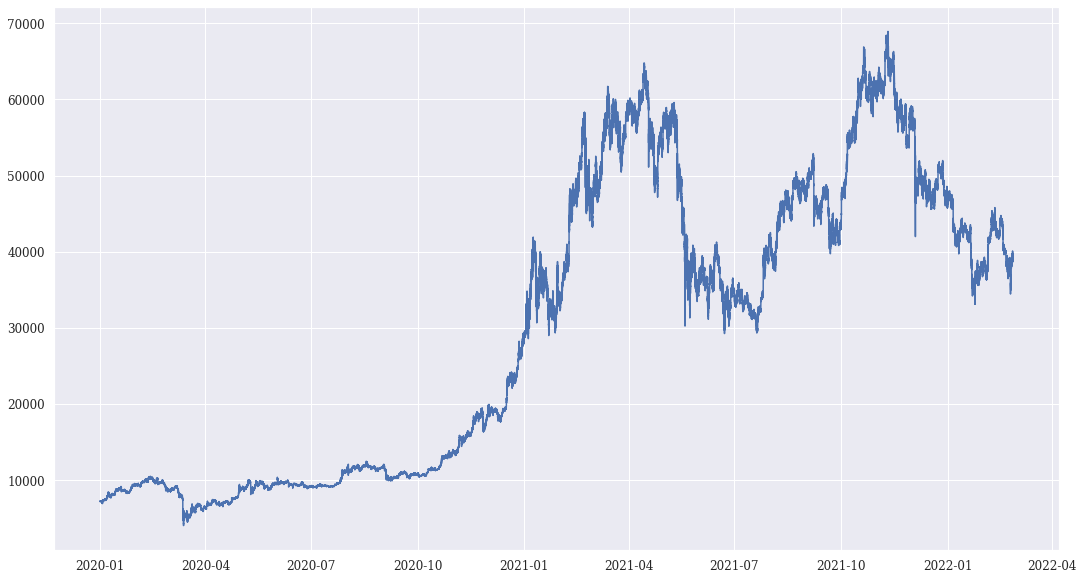

In [19]:
plt.plot(BTC_2yr.index, BTC_2yr['close'])
plt.show()

In [20]:
BTC_y = BTC_2yr['close']
BTC_X = BTC_2yr.drop('close', axis=1)
BTC_X

,open,high,low,volume,spread,upper_shadow,lower_shadow,close-open,SMA_7,SMA_14,SMA_21,STD_DEV_7
time,,,,,,,,,,,,
2020-01-01 00:20:00,7190.276057,7193.400000,7190.200000,8.780002,3.200000,0.0,0.076057,3.123943,7193.553722,7196.663734,7197.182423,3.174209
2020-01-01 00:21:00,7192.229863,7197.100000,7191.500000,8.148889,5.600000,0.0,0.729863,4.870137,7193.810865,7196.878020,7197.044327,3.403854
2020-01-01 00:22:00,7192.700000,7197.675999,7191.900000,7.596915,5.775999,0.0,0.800000,4.975999,7193.936008,7196.868004,7196.933661,3.545233
2020-01-01 00:23:00,7193.000000,7195.200000,7193.000000,3.716319,2.200000,0.0,0.000000,2.200000,7193.850294,7196.403718,7196.703251,3.499615
2020-01-01 00:24:00,7194.700000,7194.700000,7193.600000,0.025000,1.100000,0.0,0.000000,-1.100000,7193.636008,7195.796575,7196.398490,3.455992
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-26 10:48:00,39000.000000,39012.000000,39000.000000,0.168502,12.000000,0.0,0.000000,12.000000,38984.857143,38988.195477,38997.979571,24.504616
2022-02-26 10:49:00,39008.000000,39008.000000,38971.410904,1.341707,36.589096,0.0,4.589096,-32.000000,38990.142857,38983.266905,38998.455762,15.181442
2022-02-26 10:50:00,38971.755285,39029.000000,38967.949394,6.989503,61.050606,0.0,3.805891,57.244715,38999.000000,38983.571429,38998.771462,17.358955


# For testing

In [20]:
# # Only URL works, S3URI requires credentials
# BTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/btcusd.csv"
# BTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/btcusd.csv"
# ETH_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/etcusd.csv"
# ETH_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/etcusd.csv"
# LTC_USD_S3URI = "s3://cryptocurrency-forecasting/raw_data/ltcusd.csv"
# LTC_USD_URL = "https://cryptocurrency-forecasting.s3.ap-northeast-1.amazonaws.com/raw_data/ltcusd.csv"

# def get_data(crypto, last_rows=500000):
#     """ Get dataset of selected crypto from cloud storage
#     500,000 data points (mins) is roughly equivalent to 1 year worth of data
#     # Params: chosen crypto by the user from the front end """
#     if crypto == "BTC":
#         df_full = pd.read_csv(BTC_USD_URL)
#         n_rows = len(df_full)
#         df = pd.read_csv(BTC_USD_URL, skiprows=range(1, n_rows - last_rows))
#     elif crypto == 'ETH':
#         df_full = pd.read_csv(ETH_USD_URL)
#         n_rows = len(df_full)
#         df = pd.read_csv(ETH_USD_URL, skiprows=range(1, n_rows - last_rows))
#     elif crypto == 'LTC':
#         df_full = pd.read_csv(LTC_USD_URL)
#         n_rows = len(df_full)
#         df = pd.read_csv(LTC_USD_URL, skiprows=range(1, n_rows - last_rows))
#     return df

# def MinMax_fit_transform(X):
#     MinMaxscaler = MinMaxScaler()
#     MinMaxscaler.fit(X)
#     X_transformed = MinMaxscaler.fit_transform(X)
#     return X_transformed, MinMaxscaler

# def MinMax_reverse_fit_transform(MinMaxscaler, X_transformed):
#     X = MinMaxscaler.inverse_transform(X_transformed)
#     return X


# # For testing
# LTC = get_data('LTC')
# print(LTC)
# LTC_transformed, MinMaxscaler = MinMax_fit_transform(LTC)
# print(LTC_transformed)
# LTC_original = MinMax_reverse_fit_transform(MinMaxscaler, LTC_transformed)
# print(LTC_original)

# Utils function

In [21]:
# Memory saving function 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# LSTM model

In [24]:
def daily_data(df,step=1):
    df_sampled = df[['open']].resample(f'{step}D').first()
    df_sampled['close'] = df[['close']].resample(f'{step}D').last()
    df_sampled['high'] = df[[ 'high' ]].resample(f'{step}D').max()
    df_sampled['low']= df[[ 'low' ]].resample(f'{step}D').min()
    df_sampled['volume'] = df[['volume']].resample(f'{step}D').sum()
    df_sampled.interpolate(inplace=True)
    return df_sampled

BTC_day = daily_data(BTC)
BTC_day

,open,close,high,low,volume
time,,,,,
2013-04-01,93.250000,103.999000,105.900000,92.49999,5224.401313
2013-04-02,104.000000,118.229354,118.386700,99.00000,8376.527478
2013-04-03,117.958261,134.700000,146.880000,101.51088,12996.245072
2013-04-04,134.716560,132.899000,143.000000,119.00000,6981.668305
2013-04-05,130.100010,142.300000,145.000000,128.25000,5234.882203
...,...,...,...,...,...
2022-02-22,37078.000000,38299.000000,38485.000000,36402.00000,6204.849429
2022-02-23,38294.000000,37305.000000,39310.000000,37117.00000,5807.624625
2022-02-24,37305.000000,38383.000000,39926.000000,34425.00000,17875.338400


In [25]:
BTC_day.isnull().sum()

open      0
close     0
high      0
low       0
volume    0
dtype: int64

In [26]:
BTC_day_y = BTC_day['close'][14:]  #  Exclude the first 14 days 
# BTC_day_X = BTC_day.drop('close', axis=1)[:-14]  # Exclude the last 14 days
BTC_day_X = BTC_day[:-14]  # Exclude the last 14 days, no need to drop 'close' as it'll be a feature also
print(BTC_day_X.shape, BTC_day_y.shape)

(3240, 5) (3240,)


In [ ]:
# 70% for training, 30% for testing
# index_70pct = int(len(BTC_X)*0.7)
# BTC_X_train = BTC_X[:index_70pct]
# BTC_X_test = BTC_X[index_70pct:]
# BTC_y_train = BTC_y[:index_70pct]
# BTC_y_test = BTC_y[index_70pct:]

# # Use simple 70:30 train minutes data
# print(BTC_X_train.shape, BTC_X_test.shape, BTC_y_train.shape, BTC_y_test.shape)

In [27]:
# Reduce memory usage of df's:
BTC_day_X = reduce_mem_usage(BTC_day_X)
# Cannot reduce mem for BTC_day_y as it'll result in error

Memory usage of dataframe is 0.15 MB
Memory usage after optimization is: 0.09 MB
Decreased by 41.7%


/tmp/ipykernel_1090398/3377867578.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)


In [28]:
scaler_X = MinMaxScaler()
BTC_day_X_scaled = scaler_X.fit_transform(BTC_day_X)

scaler_y = MinMaxScaler()
values_BTC_day_y = BTC_day_y.values.reshape(-1, 1)
BTC_day_y_scaled = scaler_y.fit_transform(values_BTC_day_y) 
print(BTC_day_X_scaled.shape, BTC_day_y_scaled.shape)

(3240, 5) (3240, 1)


In [29]:
BTC_day_X_scaled

array([[4.0216499e-04, 5.6150404e-04, 4.7383492e-04, 1.3944758e-03,
        1.9034490e-02],
       [5.6151894e-04, 7.7244954e-04, 6.5510441e-04, 1.4924768e-03,
        3.0518889e-02],
       [7.6843088e-04, 1.0166042e-03, 1.0687418e-03, 1.5303334e-03,
        4.7350287e-02],
       ...,
       [6.5773726e-01, 6.4451462e-01, 6.6525239e-01, 6.5165991e-01,
        2.6700161e-02],
       [6.4457393e-01, 6.2780839e-01, 6.3717651e-01, 6.3338649e-01,
        2.0439900e-02],
       [6.2786770e-01, 6.2522906e-01, 6.2369019e-01, 6.2893879e-01,
        9.7012445e-03]], dtype=float32)

In [30]:
print(np.isnan(BTC_day_X).sum())
print(np.isnan(BTC_day_y).sum())

open      0
close     0
high      0
low       0
volume    0
dtype: int64
0


In [31]:
# Set the index to divide data into train, val, and test sets
index_70pct = int(len(BTC_day_X)*0.7)
index_85pct = int(len(BTC_day_X)*0.85)
print(len(BTC_day_X))
print(index_70pct)
print(index_85pct)

3240
2268
2754


In [32]:
# Define time series generator
seq_len = 30 # Length of each sequence
# window_size = seq_len - 1
# prediction_len = 32
batch_size = 32 # Number of observations
n_features = 5

train_generator = TimeseriesGenerator(BTC_day_X_scaled, BTC_day_y_scaled, length=seq_len, batch_size=batch_size, end_index = index_70pct)
val_generator = TimeseriesGenerator(BTC_day_X_scaled, BTC_day_y_scaled, length=seq_len, batch_size=batch_size, \
                                    start_index = index_70pct, end_index = index_85pct)
test_generator = TimeseriesGenerator(BTC_day_X_scaled, BTC_day_y_scaled, length=seq_len, batch_size=batch_size, start_index = index_85pct)

In [33]:
X_train, y_train = train_generator[0]
print(X_train.shape)
print(y_train.shape)
print(f'Given the Array: \n{X_train.flatten()}')
print(f'Predict this y: \n {y_train}')

X_val , y_val = val_generator[0]
print(X_val.shape)
print(y_val.shape)
print(f'Given the Array: \n{X_val.flatten()}')
print(f'Predict this y: \n {y_val}')

X_test , y_test = test_generator[0]
print(X_test.shape)
print(y_test.shape)
print(f'Given the Array: \n{X_test.flatten()}')
print(f'Predict this y: \n {y_test}')

(32, 30, 5)
(32, 1)
Given the Array: 
[0.00040216 0.0005615  0.00047383 ... 0.00081063 0.00188538 0.00826129]
Predict this y: 
 [[0.0006349 ]
 [0.00072458]
 [0.00076342]
 [0.00077676]
 [0.00077276]
 [0.00077038]
 [0.00075423]
 [0.0007855 ]
 [0.00085547]
 [0.00092766]
 [0.00093166]
 [0.00095049]
 [0.00089134]
 [0.00088023]
 [0.00095212]
 [0.00089802]
 [0.0009158 ]
 [0.0009287 ]
 [0.00085503]
 [0.00084465]
 [0.00080507]
 [0.00081634]
 [0.00078802]
 [0.00066632]
 [0.00063756]
 [0.00050222]
 [0.00056419]
 [0.00061133]
 [0.00060125]
 [0.00053187]
 [0.0004874 ]
 [0.00049363]]
(32, 30, 5)
(32, 1)
Given the Array: 
[0.13222347 0.1376845  0.13670284 ... 0.15235217 0.14740813 0.04696522]
Predict this y: 
 [[0.1485606 ]
 [0.15318557]
 [0.1549644 ]
 [0.15944114]
 [0.1616795 ]
 [0.17429441]
 [0.16907649]
 [0.17688854]
 [0.17764455]
 [0.17528759]
 [0.16669582]
 [0.17046039]
 [0.16806849]
 [0.16065683]
 [0.1482131 ]
 [0.15206291]
 [0.15272604]
 [0.1506359 ]
 [0.15218041]
 [0.16116068]
 [0.15899844]
 

In [ ]:
# Good model so far has test MSE = 147,201,714
# def init_model():
#     model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
#     model.add(LSTM(units=64, activation='tanh'))
#     model.add(Dense(64, activation = 'LeakyReLU'))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation='linear'))
#     return model

# def compile_model(model): 
#     Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
#     model.compile(loss='mse', 
#         optimizer = Adam_opt,
#         metrics='mse')
#     return model

In [34]:
# One model predicts "High" that can act as upper bound
# One model predicts "Low" that can act as lower bound

def init_model():
    model = Sequential()
    model.add(GRU(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
    model.add(GRU(units=64, activation='tanh'))
    model.add(Dense(64, activation = 'LeakyReLU'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    return model

def compile_model(model): 
    Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mse', 
        optimizer = Adam_opt,
        metrics='mae')
    return model

model = init_model()
compile_model(model)
model.summary()

2022-03-19 21:15:14.085309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 21:15:14.086557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 21:15:14.086723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-19 21:15:14.086876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-19 21:15:14.130241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           51840     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,313
Trainable params: 93,313
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 9.6242e-04 - mae: 0.0204

2022-03-19 21:15:26.760701: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


70/70 [==============================] - 8s 85ms/step - loss: 9.6242e-04 - mae: 0.0204 - val_loss: 8.5229e-04 - val_mae: 0.0253
Epoch 2/50
69/70 [============================>.] - ETA: 0s - loss: 3.8136e-04 - mae: 0.0109

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


70/70 [==============================] - 6s 80ms/step - loss: 3.7653e-04 - mae: 0.0108 - val_loss: 3.1086e-04 - val_mae: 0.0133
Epoch 3/50
70/70 [==============================] - 2s 30ms/step - loss: 3.4565e-04 - mae: 0.0118 - val_loss: 6.8689e-04 - val_mae: 0.0220
Epoch 4/50
70/70 [==============================] - 2s 29ms/step - loss: 5.8994e-04 - mae: 0.0182 - val_loss: 6.6030e-04 - val_mae: 0.0219
Epoch 5/50
70/70 [==============================] - 2s 29ms/step - loss: 4.2498e-04 - mae: 0.0115 - val_loss: 6.4312e-04 - val_mae: 0.0213
Epoch 6/50
70/70 [==============================] - 2s 29ms/step - loss: 3.0793e-04 - mae: 0.0094 - val_loss: 3.5696e-04 - val_mae: 0.0148
Epoch 7/50
70/70 [==============================] - 2s 29ms/step - loss: 3.7928e-04 - mae: 0.0110 - val_loss: 0.0015 - val_mae: 0.0354


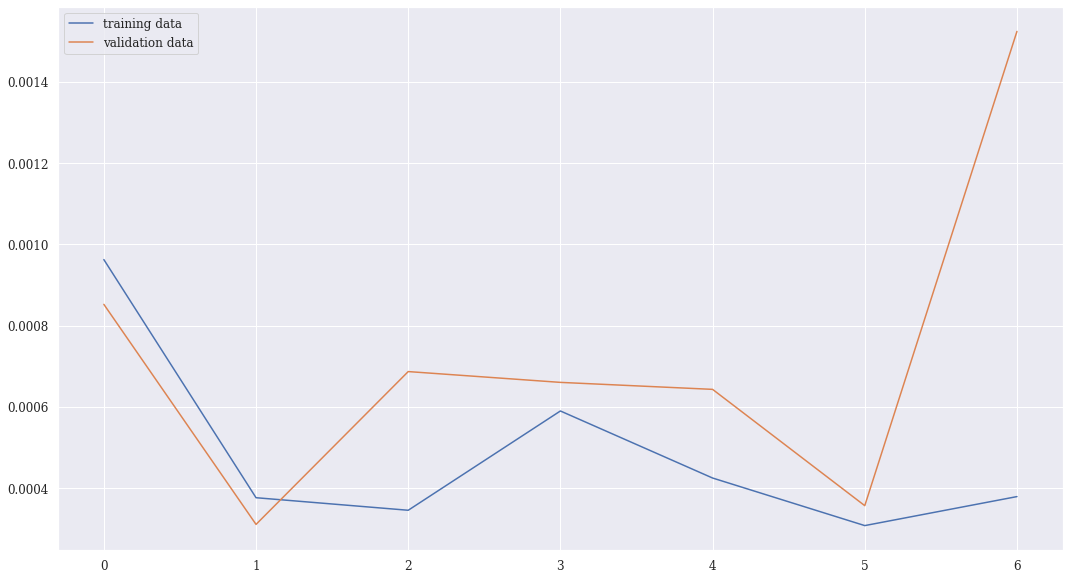

In [35]:
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
# current_path is the default path of the os.getcwd()
cp = tf.keras.callbacks.ModelCheckpoint(current_path, monitor='val_loss', save_best_only=True)
history = model.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es, cp])
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.legend()
plt.show()

Actual training data has length (2268,)
Predicted training data has length 2239 (2239, 1)


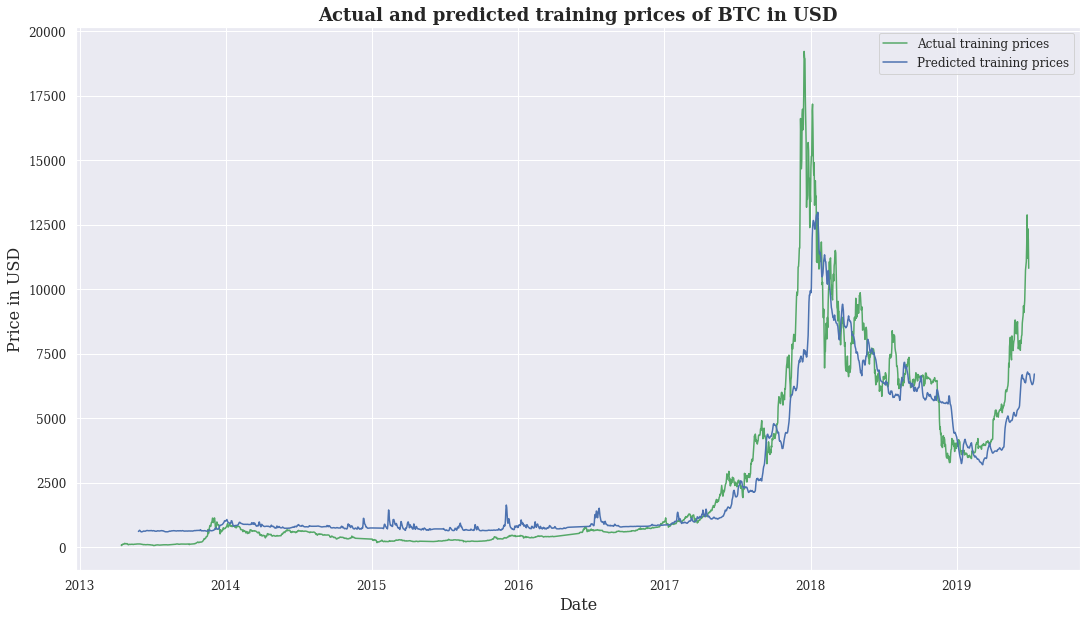

In [36]:
# Predict with training data
BTC_y_pred = model.predict(train_generator)
# print(BTC_y_pred)

# Inverse transform the data back
BTC_y_pred_prices = scaler_y.inverse_transform(BTC_y_pred)
print('Actual training data has length', BTC_day_y[:index_70pct].shape)
print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
# print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[13:index_70pct]))

plt.plot(BTC_day_y[:index_70pct].index, BTC_day_y[:index_70pct].values, color = 'g', label = 'Actual training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_day_y[43:index_70pct+14].index, BTC_y_pred_prices, color = 'b', label = 'Predicted training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64


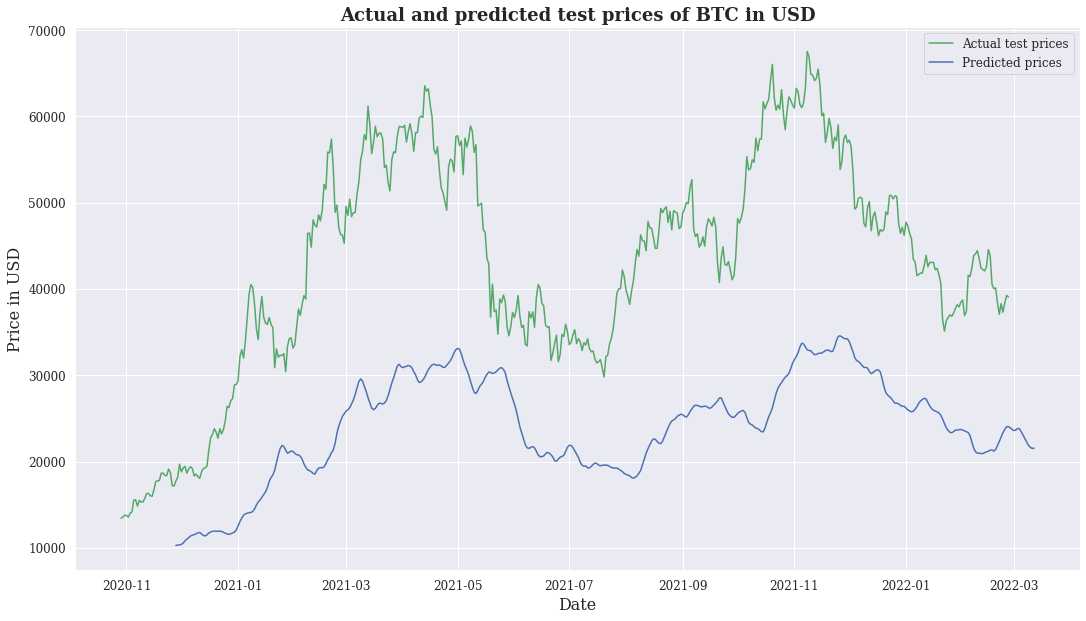

In [37]:
def predict_put_results_in_df_and_plot(model, generator_set):
  # Actual prices from the data
  df_actual = pd.DataFrame({'actual_price':  BTC_day_y[index_85pct:].values, 'date': BTC_day_y[index_85pct:].index})
  
  # Predicted prices from the given generator set
  BTC_y_pred = model.predict(generator_set)
  BTC_y_pred_prices = scaler_y.inverse_transform(BTC_y_pred)
  days_in_sample_pred = BTC_day_y[index_85pct+30:].index
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': BTC_y_pred_prices.reshape(len(BTC_y_pred_prices)), 'date': days_in_sample_pred})

  # Get the extra days for future predicted prices
  days_future_pred = BTC_day_y[-14:].index + timedelta(14)
  # Get the last 30 days of X, and it'll predict close of 14 days later
  scaled_BTC_day = scaler_X.transform(BTC_day)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_BTC_day[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y.inverse_transform(y_pred)
  # Get the dates for the future preds
  days_plot_new_pred = BTC_day_y[-14:].index + timedelta(14)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print(df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

df_plot = predict_put_results_in_df_and_plot(model, test_generator)
plt.plot(df_plot['actual_price'], color = 'g', label = 'Actual test prices')
plt.plot(df_plot['pred_future_price'], color = 'b', label = 'Predicted prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()

In [40]:
# # Only need to run once per day or if notebook times out, whichever comes first, can change with the new date each time
EXPERIMENT_NAME = "[Crypto forecasting] Mar 19th experiment - 2"
mlflow.set_tracking_uri("https://mlflow.lewagon.co/")

# # Only need to run once
client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)
run = client.create_run(experiment_id)

Actual test data has length (486,)
Predicted test data has length 456 (456, 1)
The test MSE is 473301628.53761333


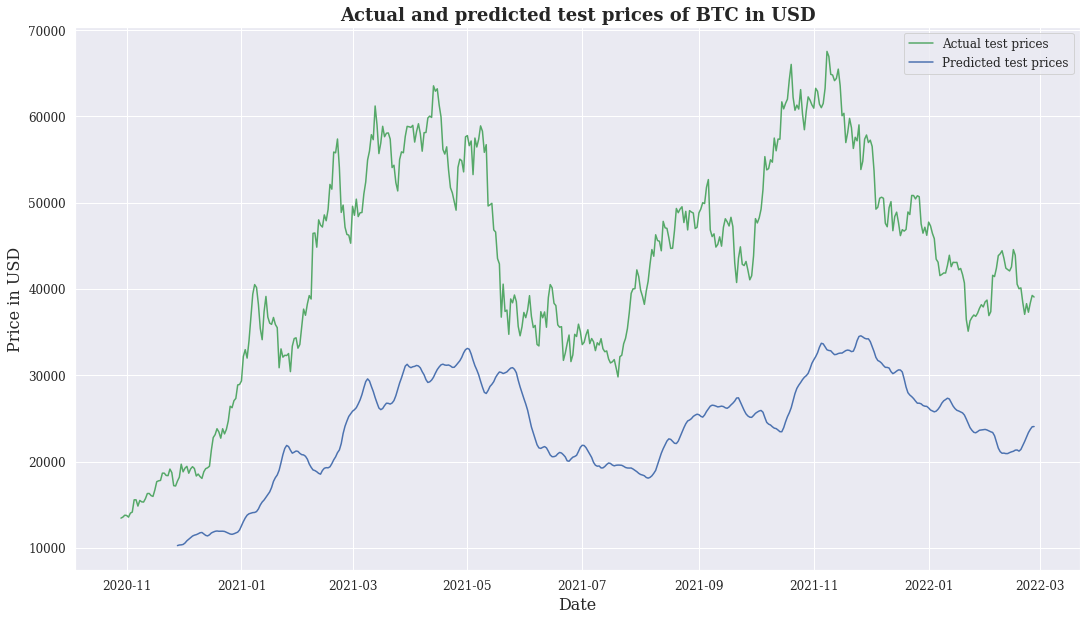

In [41]:
# Predict with test data
BTC_y_pred_test = model.predict(test_generator)
# print(BTC_y_pred_test)

# Inverse transform the data back
BTC_y_pred_test_prices = scaler_y.inverse_transform(BTC_y_pred_test)
print('Actual test data has length', BTC_day_y[index_85pct:].shape)
print('Predicted test data has length', len(BTC_y_pred_test_prices), BTC_y_pred_test_prices.shape)
print('The test MSE is', mean_squared_error(BTC_y_pred_test_prices, BTC_day_y[index_85pct+30:]))

plt.plot(BTC_day_y[index_85pct:].index, BTC_day_y[index_85pct:].values, color = 'g', label = 'Actual test prices')
# Shift index by 30 days forward for predicted prices to get the right dates
plt.plot(BTC_day_y[index_85pct+30:].index, BTC_y_pred_test_prices, color = 'b', label = 'Predicted test prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()
# Track and log the experiment's metrics and params
client.log_metric(run.info.run_id, "mse", mean_squared_error(BTC_y_pred_test_prices, BTC_day_y[index_85pct+30:]))
client.log_metric(run.info.run_id, "mae", mean_absolute_error(BTC_y_pred_test_prices, BTC_day_y[index_85pct+30:]))
client.log_param(run.info.run_id, "model", 'LSTM model with Time Series Generator')
client.log_param(run.info.run_id, "Number of neurons", [128, 64, 32, 32, 0.4, 1])
client.log_param(run.info.run_id, "seq_len", 30)
client.log_param(run.info.run_id, "batch_size", 32)

In [42]:
# Get the last 30 days of X, and it'll predict close of 14 days later
scaled_BTC_day = scaler_X.transform(BTC_day)

seq_X = []
for i in range(14):
  seq_X.append(scaled_BTC_day[-44+i:-14+i])

seq_X = np.array(seq_X)
print(seq_X.shape)

(14, 30, 5)


In [43]:
y_pred = model.predict(seq_X)
y_pred_prices = scaler_y.inverse_transform(y_pred)
days_plot_new_pred = BTC_day_y[-14:].index + timedelta(14)
print(y_pred_prices.shape, y_pred_prices)
print(days_plot_new_pred.shape)
y_pred_df = pd.DataFrame({'pred_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
y_pred_df.set_index('date', inplace=True)
y_pred_df 

(14, 1) [[23905.299]
 [23724.93 ]
 [23588.295]
 [23665.658]
 [23836.166]
 [23804.127]
 [23450.475]
 [23058.2  ]
 [22660.902]
 [22256.824]
 [21863.291]
 [21642.604]
 [21517.459]
 [21563.64 ]]
(14,)


,pred_price
date,
2022-02-27,23905.298828
2022-02-28,23724.929688
2022-03-01,23588.294922
2022-03-02,23665.658203
2022-03-03,23836.166016
2022-03-04,23804.126953
2022-03-05,23450.474609
2022-03-06,23058.199219
2022-03-07,22660.902344


# Alternate LSTM with just data from beginning of 2020 only

In [44]:
BTC_since_2020 = BTC['2020-01-01':]
BTC_day_2020 = daily_data(BTC_since_2020)

# Get all the features 
BTC_day_2020 = get_features(BTC_day_2020)
BTC_day_2020

,open,close,high,low,volume,spread,upper_shadow,lower_shadow,close-open,SMA_7,SMA_14,SMA_21,STD_DEV_7
time,,,,,,,,,,,,,
2020-01-21,8638.200000,8734.100000,8787.174174,8500.0,3250.966055,287.174174,53.074174,138.200000,95.900000,8766.614286,8461.560819,8127.694439,94.358243
2020-01-22,8734.200000,8663.900000,8799.900000,8580.5,2350.330470,219.400000,65.700000,83.400000,-70.300000,8746.071429,8506.353676,8196.799201,99.439256
2020-01-23,8663.800000,8403.568517,8670.400000,8296.0,5703.898554,374.400000,6.600000,107.568517,-260.231483,8700.781217,8548.219180,8264.140559,164.129025
2020-01-24,8403.568517,8447.129673,8523.000000,8246.0,3508.589672,277.000000,75.870327,157.568517,43.561156,8639.599741,8566.978442,8315.375306,167.965868
2020-01-25,8447.100000,8353.700000,8447.200000,8280.0,2101.665990,167.200000,0.100000,73.700000,-93.400000,8562.756884,8591.264156,8362.226174,156.085424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,37078.000000,38299.000000,38485.000000,36402.0,6204.849429,2083.000000,186.000000,676.000000,1221.000000,39774.048432,41447.381359,41329.635192,2206.683846
2022-02-23,38294.000000,37305.000000,39310.000000,37117.0,5807.624625,2193.000000,1016.000000,188.000000,-989.000000,38830.619861,40938.381359,41348.301858,1413.311418
2022-02-24,37305.000000,38383.000000,39926.000000,34425.0,17875.338400,5501.000000,1543.000000,2880.000000,1078.000000,38520.334147,40569.667073,41396.730430,1192.869866


In [45]:
BTC_2020_y = BTC_day_2020['close'][14:]  #  Exclude the first 14 days 
BTC_2020_X = BTC_day_2020[:-14]  # Exclude the last 14 days, no need to drop 'close' as it'll be a feature also
print(BTC_2020_X.shape, BTC_2020_y.shape)

(754, 13) (754,)


In [46]:
scaler_X_2020 = MinMaxScaler()
BTC_2020_X_scaled = scaler_X_2020.fit_transform(BTC_2020_X)

scaler_y_2020 = MinMaxScaler()
values_BTC_2020_y = BTC_2020_y.values.reshape(-1, 1)
BTC_2020_y_scaled = scaler_y_2020.fit_transform(values_BTC_2020_y) 
print(BTC_2020_X_scaled.shape, BTC_2020_y_scaled.shape)

(754, 13) (754, 1)


In [47]:
# Set the index to divide data into train, val, and test sets
index_70pct = int(len(BTC_2020_X)*0.7) # end of training set
index_85pct = int(len(BTC_2020_X)*0.85) # end of val set and beginning of test set
print(len(BTC_2020_X))
print(index_70pct)
print(index_85pct)

754
527
640


In [48]:
# Define time series generator
seq_len = 30 # Length of each sequence
batch_size = 32 # Number of observations
n_features = 13

train_generator = TimeseriesGenerator(BTC_2020_X_scaled, BTC_2020_y_scaled, length=seq_len, batch_size=batch_size, end_index = index_70pct)
val_generator = TimeseriesGenerator(BTC_2020_X_scaled, BTC_2020_y_scaled, length=seq_len, batch_size=batch_size, \
                                    start_index = index_70pct, end_index = index_85pct)
test_generator = TimeseriesGenerator(BTC_2020_X_scaled, BTC_2020_y_scaled, length=seq_len, batch_size=batch_size, start_index = index_85pct)

In [49]:
# Best model so far with 2020+ data and test MSE is 12,012,549 with architecture (128, 64, 64, 0.2, 1)
def init_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
    model.add(LSTM(units=64, activation='tanh'))
    model.add(Dense(64, activation = 'LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

def compile_model(model): 
    Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mse', 
        optimizer = Adam_opt,
        metrics='mse')
    return model

model2 = init_model()
compile_model(model2)
model2.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0631 - mse: 0.0631

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


16/16 [==============================] - 6s 278ms/step - loss: 0.0611 - mse: 0.0611 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0663 - val_mse: 0.0663
Epoch 3/50
16/16 [==============================] - 1s 32ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 5/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 6/50
16/16 [==============================] - 1s 32ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0740 - val_mse: 0.0740
Epoch 7/50
16/16 [==============================] - 1s 32ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 8/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0130 - mse: 0.0130

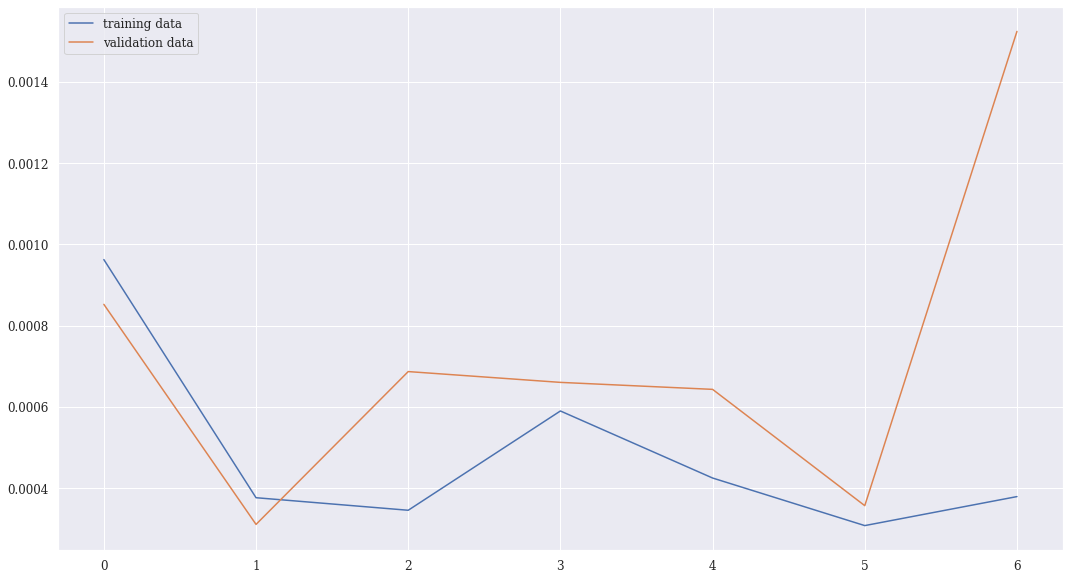

In [50]:
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# current_path is the default path of the os.getcwd()
cp = tf.keras.callbacks.ModelCheckpoint(current_path, monitor='val_loss', save_best_only=True)
history2 = model2.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es, cp])
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.legend()
plt.show()

Actual training data has length (527,)
Predicted training data has length 498 (498, 1)
The MSE is 765149777.5103023


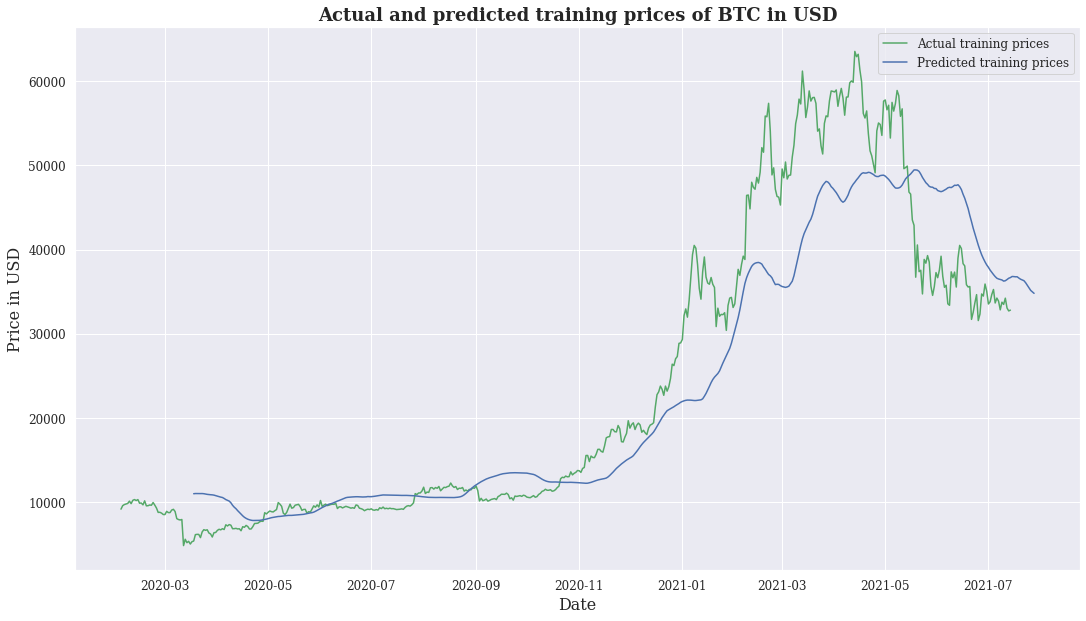

In [51]:
# Predict with training data
BTC_y_pred = model2.predict(train_generator)

# Inverse transform the data back
BTC_y_pred_prices = scaler_y_2020.inverse_transform(BTC_y_pred)
print('Actual training data has length', BTC_2020_y[:index_70pct].shape)
print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[29:index_70pct]))

plt.plot(BTC_2020_y[:index_70pct].index, BTC_2020_y[:index_70pct].values, color = 'g', label = 'Actual training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_2020_y[43:index_70pct+14].index, BTC_y_pred_prices, color = 'b', label = 'Predicted training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64


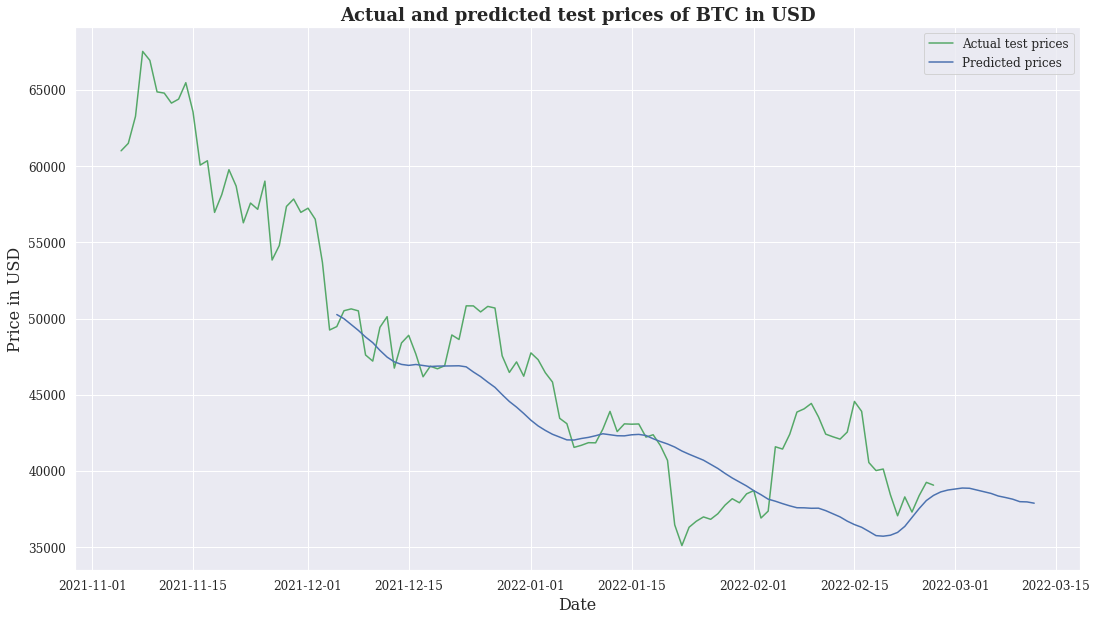

In [52]:
def predict_put_results_in_df_and_plot_2020(model, generator_set):
  # Actual prices from the data
  df_actual = pd.DataFrame({'actual_price':  BTC_2020_y[index_85pct:].values, 'date': BTC_2020_y[index_85pct:].index})
  
  # Predicted prices from the given generator set
  BTC_y_pred = model.predict(generator_set)
  BTC_y_pred_prices = scaler_y_2020.inverse_transform(BTC_y_pred)
  days_in_sample_pred = BTC_2020_y[index_85pct+30:].index
  # print(days_in_sample_pred)
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': BTC_y_pred_prices.reshape(len(BTC_y_pred_prices)), 'date': days_in_sample_pred})

  # Get the extra days for future predicted prices
  days_future_pred = BTC_2020_y[-14:].index + timedelta(14)
  # Get the last 30 days of X, and it'll predict close of 14 days later
  scaled_BTC_day_2020 = scaler_X_2020.transform(BTC_day_2020)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_BTC_day_2020[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y_2020.inverse_transform(y_pred)
  # Get the dates for the future preds
  days_plot_new_pred = BTC_2020_y[-14:].index + timedelta(14)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print(df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

df_plot = predict_put_results_in_df_and_plot_2020(model2, test_generator)
plt.plot(df_plot['actual_price'], color = 'g', label = 'Actual test prices')
plt.plot(df_plot['pred_future_price'], color = 'b', label = 'Predicted prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()

In [53]:
# Price predicton of future 14 days
df_plot.tail(14)

,actual_price,pred_in_sample_price,pred_future_price
date,,,
2022-02-27,NaN,NaN,38625.847656
2022-02-28,NaN,NaN,38750.250000
2022-03-01,NaN,NaN,38812.281250
2022-03-02,NaN,NaN,38880.757812
2022-03-03,NaN,NaN,38865.960938
2022-03-04,NaN,NaN,38752.570312
2022-03-05,NaN,NaN,38640.414062
2022-03-06,NaN,NaN,38526.789062
2022-03-07,NaN,NaN,38357.875000


In [54]:
# Only need to run once per day or if notebook times out, whichever comes first, can change with the new date each time
EXPERIMENT_NAME = "[Crypto forecasting] Mar 19th LSTM 5-layer experiment 3 models with 2020+ data - 2"
mlflow.set_tracking_uri("https://mlflow.lewagon.co/")

# Only need to run once
client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)
run = client.create_run(experiment_id)

Actual test data has length (114,)
Predicted test data has length 84 (84, 1)
The test MSE is 10760275.781687316


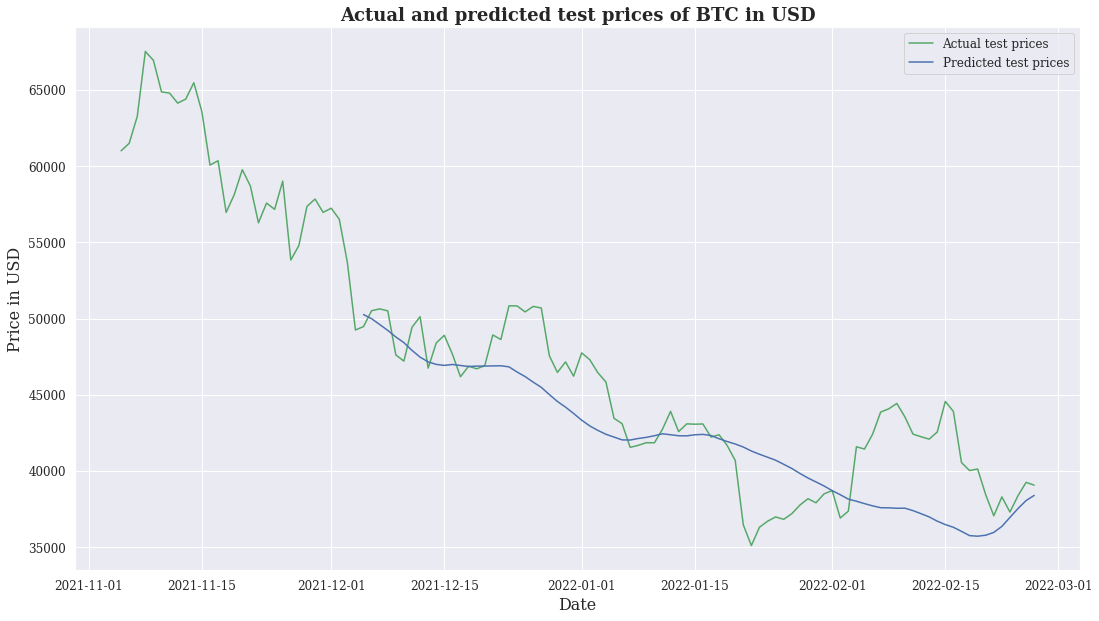

In [55]:
# Predict with test data
BTC_y_pred_test = model2.predict(test_generator)
# print(BTC_y_pred_test)

# Inverse transform the data back
BTC_y_pred_test_prices = scaler_y_2020.inverse_transform(BTC_y_pred_test)
print('Actual test data has length', BTC_2020_y[index_85pct:].shape)
print('Predicted test data has length', len(BTC_y_pred_test_prices), BTC_y_pred_test_prices.shape)
print('The test MSE is', mean_squared_error(BTC_y_pred_test_prices, BTC_2020_y[index_85pct+30:]))

plt.plot(BTC_2020_y[index_85pct:].index, BTC_2020_y[index_85pct:].values, color = 'g', label = 'Actual test prices')
# Shift index by 30 days forward for predicted prices to get the right dates
plt.plot(BTC_2020_y[index_85pct+30:].index, BTC_y_pred_test_prices, color = 'b', label = 'Predicted test prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()
# Track and log the experiment's metrics and params
client.log_metric(run.info.run_id, "mse", mean_squared_error(BTC_y_pred_test_prices, BTC_2020_y[index_85pct+30:]))
client.log_metric(run.info.run_id, "mae", mean_absolute_error(BTC_y_pred_test_prices, BTC_2020_y[index_85pct+30:]))
client.log_param(run.info.run_id, "model", 'LSTM model with Time Series Generator with 2020+ data')
client.log_param(run.info.run_id, "Number of neurons", [128, 64, 64, 0.1, 1])
client.log_param(run.info.run_id, "seq_len", 30)
client.log_param(run.info.run_id, "batch_size", 32)

# LSTM with 1-year data since 2021

In [56]:
BTC_since_2021 = BTC['2021-01-01':]
BTC_day_2021 = daily_data(BTC_since_2021)
# Equip with 13 features
BTC_day_2021 = get_features(BTC_day_2021)

BTC_2021_y = BTC_day_2021['close'][14:]  #  Exclude the first 14 days 
BTC_2021_X = BTC_day_2021[:-14]  # Exclude the last 14 days, no need to drop 'close' as it'll be a feature also
print('Shape of data since 2021 for BTC is', BTC_2021_X.shape, BTC_2021_y.shape)

scaler_X_2021 = MinMaxScaler()
BTC_2021_X_scaled = scaler_X_2021.fit_transform(BTC_2021_X)

scaler_y_2021 = MinMaxScaler()
values_BTC_2021_y = BTC_2021_y.values.reshape(-1, 1)
BTC_2021_y_scaled = scaler_y_2021.fit_transform(values_BTC_2021_y) 
print('Shape of BTC data after scaled is', BTC_2021_X_scaled.shape, BTC_2021_y_scaled.shape)

# Set the index to divide data into train, val, and test sets
index_70pct = int(len(BTC_2021_X)*0.7) # end of training set
index_85pct = int(len(BTC_2021_X)*0.85) # end of val set and beginning of test set
print('Length of entire data is', len(BTC_2021_X))
print('The ending index for training set is', index_70pct)
print('The beginning index for test set (also the ending index for val set) is', index_85pct)

Shape of data since 2021 for BTC is (388, 13) (388,)
Shape of BTC data after scaled is (388, 13) (388, 1)
Length of entire data is 388
The ending index for training set is 271
The beginning index for test set (also the ending index for val set) is 329


In [57]:
# Define time series generator
seq_len = 30 # Length of each sequence
batch_size = 32 # Number of observations
n_features = 13

train_generator = TimeseriesGenerator(BTC_2021_X_scaled, BTC_2021_y_scaled, length=seq_len, batch_size=batch_size, end_index = index_70pct)
val_generator = TimeseriesGenerator(BTC_2021_X_scaled, BTC_2021_y_scaled, length=seq_len, batch_size=batch_size, \
                                    start_index = index_70pct, end_index = index_85pct)
test_generator = TimeseriesGenerator(BTC_2021_X_scaled, BTC_2021_y_scaled, length=seq_len, batch_size=batch_size, start_index = index_85pct)

In [58]:
# Best model so far with 2020+ data and test MSE of 14,786,877
# Best 2021+ data has test MSE of 21,831,109
def init_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
    model.add(LSTM(units=64, activation='tanh'))
    model.add(Dense(64, activation = 'LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

def compile_model(model): 
    Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mse', 
        optimizer = Adam_opt,
        metrics='mse')
    return model

model3 = init_model()
compile_model(model3)
model3.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           72704     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.2799 - mse: 0.2799

INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


8/8 [==============================] - 15s 2s/step - loss: 0.2799 - mse: 0.2799 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 2/50
8/8 [==============================] - 1s 172ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.1598 - val_mse: 0.1598
Epoch 3/50
8/8 [==============================] - 1s 130ms/step - loss: 0.1113 - mse: 0.1113 - val_loss: 0.0884 - val_mse: 0.0884
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.0511 - mse: 0.0511

INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


8/8 [==============================] - 8s 1s/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 5/50
8/8 [==============================] - 1s 112ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 6/50
8/8 [==============================] - 1s 103ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 7/50
8/8 [==============================] - 1s 110ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 8/50
8/8 [==============================] - 1s 105ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 9/50
8/8 [==============================] - 1s 98ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 10/50
8/8 [==============================] - 1s 111ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 11/50
8/8 [==============================] - 1s 108ms/step - loss: 0.0461 - mse: 0.0461 - val_loss

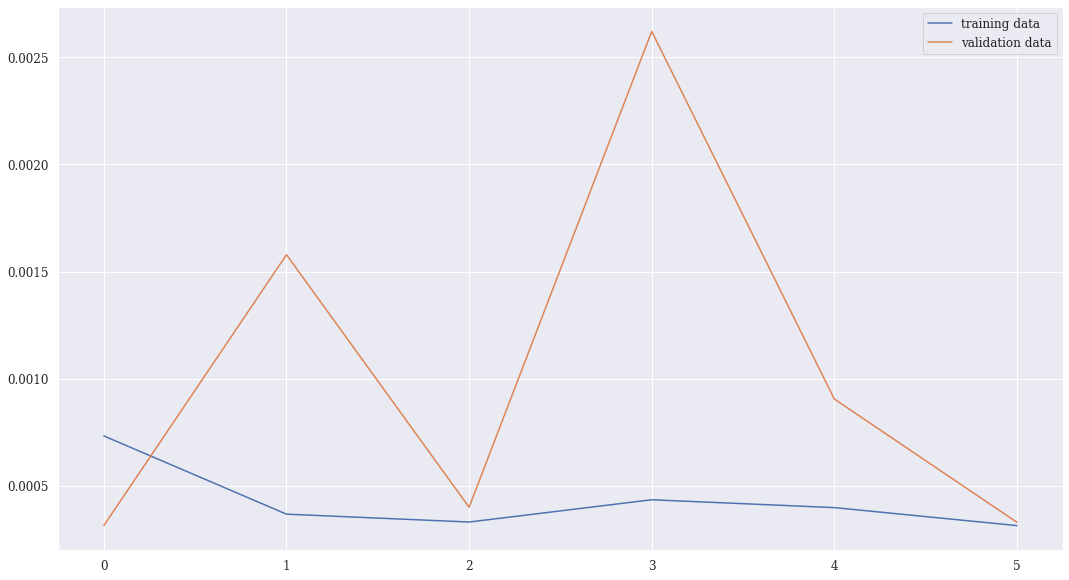

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# current_path is the default path of the os.getcwd()
cp = tf.keras.callbacks.ModelCheckpoint(current_path, monitor='val_loss', save_best_only=True)
history3 = model3.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es, cp])
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.legend()
plt.show()

Actual training data has length (271,)
Predicted training data has length 242 (242, 1)


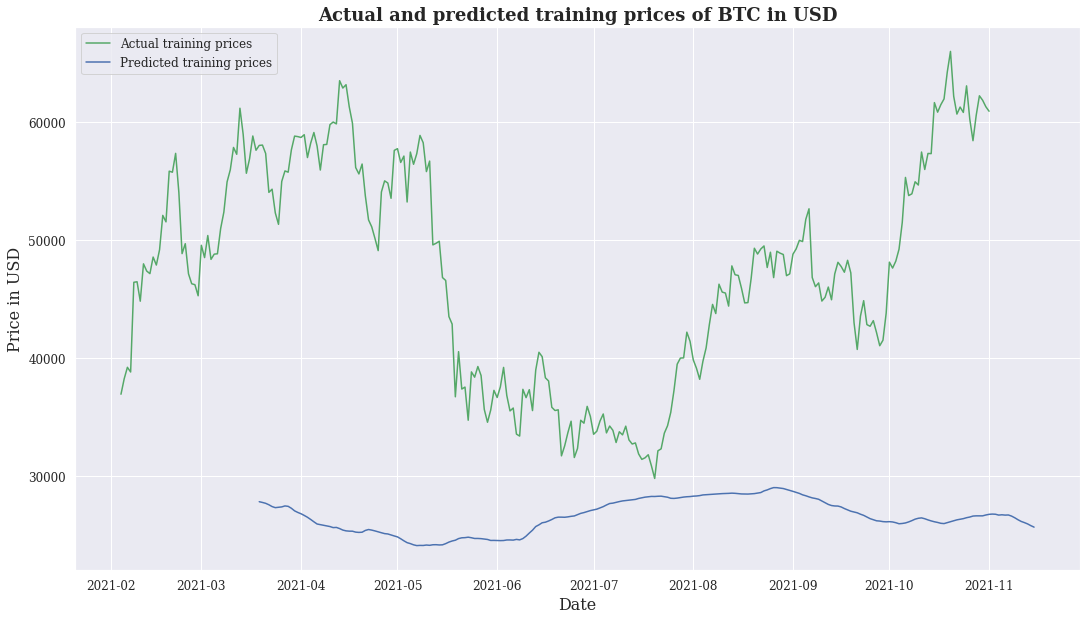

In [59]:
# Predict with training data
BTC_y_pred = model3.predict(train_generator)

# Inverse transform the data back
BTC_y_pred_prices = scaler_y_2021.inverse_transform(BTC_y_pred)
print('Actual training data has length', BTC_2021_y[:index_70pct].shape)
print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
# print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[13:index_70pct]))

plt.plot(BTC_2021_y[:index_70pct].index, BTC_2021_y[:index_70pct].values, color = 'g', label = 'Actual training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_2021_y[43:index_70pct+14].index, BTC_y_pred_prices, color = 'b', label = 'Predicted training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

Number of missing data points in each column is actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64


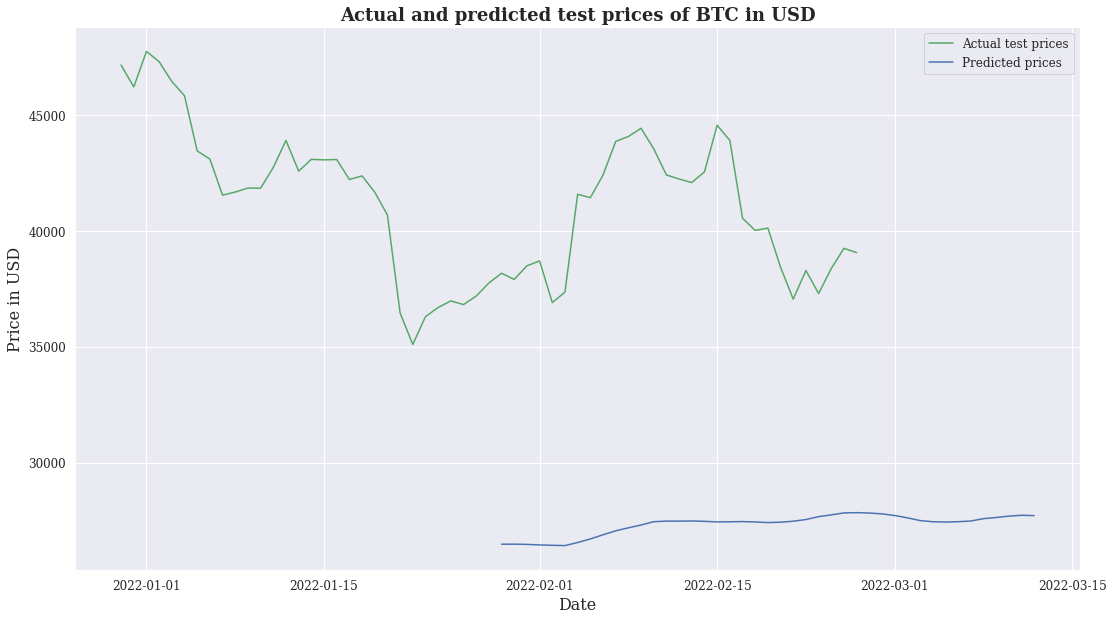

In [60]:
def predict_put_results_in_df_and_plot_2021(model, generator_set):
  # Actual prices from the data
  df_actual = pd.DataFrame({'actual_price':  BTC_2021_y[index_85pct:].values, 'date': BTC_2021_y[index_85pct:].index})
  
  # Predicted prices from the given generator set
  BTC_y_pred = model.predict(generator_set)
  BTC_y_pred_prices = scaler_y_2021.inverse_transform(BTC_y_pred)
  days_in_sample_pred = BTC_2021_y[index_85pct+30:].index
  # print(days_in_sample_pred)
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': BTC_y_pred_prices.reshape(len(BTC_y_pred_prices)), 'date': days_in_sample_pred})

  # Get the extra days for future predicted prices
  days_future_pred = BTC_2021_y[-14:].index + timedelta(14)
  # Get the last 30 days of X, and it'll predict close of 14 days later
  scaled_BTC_day_2021 = scaler_X_2021.transform(BTC_day_2021)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_BTC_day_2021[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y_2021.inverse_transform(y_pred)
  # Get the dates for the future preds
  days_plot_new_pred = BTC_2021_y[-14:].index + timedelta(14)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print('Number of missing data points in each column is', df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

df_plot = predict_put_results_in_df_and_plot_2021(model3, test_generator)
plt.plot(df_plot['actual_price'], color = 'g', label = 'Actual test prices')
plt.plot(df_plot['pred_future_price'], color = 'b', label = 'Predicted prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()

In [61]:
# Price prediction of future 14 days
df_plot.tail(14)

,actual_price,pred_in_sample_price,pred_future_price
date,,,
2022-02-27,NaN,NaN,27838.205078
2022-02-28,NaN,NaN,27800.888672
2022-03-01,NaN,NaN,27730.339844
2022-03-02,NaN,NaN,27631.650391
2022-03-03,NaN,NaN,27512.384766
2022-03-04,NaN,NaN,27461.828125
2022-03-05,NaN,NaN,27449.816406
2022-03-06,NaN,NaN,27464.152344
2022-03-07,NaN,NaN,27493.683594


Actual test data has length (59,)
Predicted test data has length 29 (29, 1)
The test MSE is 183302573.9054561


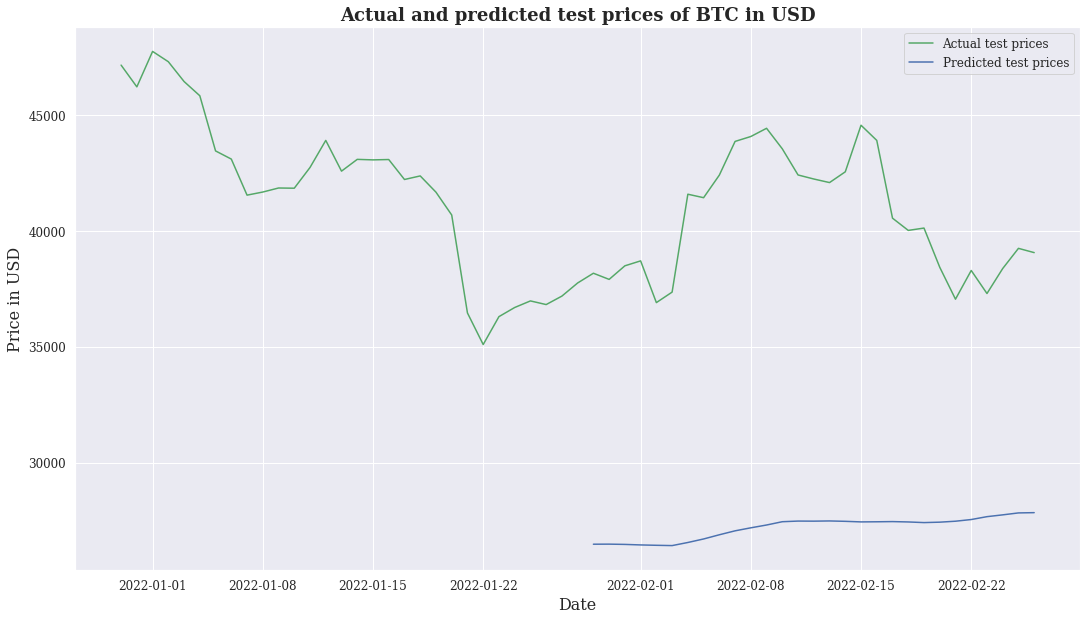

In [62]:
# Predict with test data
BTC_y_pred_test = model3.predict(test_generator)
# print(BTC_y_pred_test)

# Inverse transform the data back
BTC_y_pred_test_prices = scaler_y_2021.inverse_transform(BTC_y_pred_test)
print('Actual test data has length', BTC_2021_y[index_85pct:].shape)
print('Predicted test data has length', len(BTC_y_pred_test_prices), BTC_y_pred_test_prices.shape)
print('The test MSE is', mean_squared_error(BTC_y_pred_test_prices, BTC_2021_y[index_85pct+30:]))

plt.plot(BTC_2021_y[index_85pct:].index, BTC_2021_y[index_85pct:].values, color = 'g', label = 'Actual test prices')
# Shift index by 30 days forward for predicted prices to get the right dates
plt.plot(BTC_2021_y[index_85pct+30:].index, BTC_y_pred_test_prices, color = 'b', label = 'Predicted test prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()
# Track and log the experiment's metrics and params
# client.log_metric(run.info.run_id, "mse", mean_squared_error(BTC_y_pred_test_prices, BTC_2021_y[index_85pct+30:]))
# client.log_metric(run.info.run_id, "mae", mean_absolute_error(BTC_y_pred_test_prices, BTC_2021_y[index_85pct+30:]))
# client.log_param(run.info.run_id, "model", 'LSTM model with Time Series Generator with 2020+ data')
# client.log_param(run.info.run_id, "Number of neurons", [128, 64, 64, 0.3, 1])
# client.log_param(run.info.run_id, "seq_len", 30)
# client.log_param(run.info.run_id, "batch_size", 32)

# LSTM model with data from 2019

In [63]:
BTC_since_2019 = BTC['2019-01-01':]
BTC_day_2019 = daily_data(BTC_since_2019)
# Equip with 13 features
BTC_day_2019 = get_features(BTC_day_2019)

BTC_2019_y = BTC_day_2019['close'][14:]  #  Exclude the first 14 days 
BTC_2019_X = BTC_day_2019[:-14]  # Exclude the last 14 days, no need to drop 'close' as it'll be a feature also
print('Shape of data since 2019 for BTC is', BTC_2019_X.shape, BTC_2019_y.shape)

scaler_X_2019 = MinMaxScaler()
BTC_2019_X_scaled = scaler_X_2019.fit_transform(BTC_2019_X)

scaler_y_2019 = MinMaxScaler()
values_BTC_2019_y = BTC_2019_y.values.reshape(-1, 1)
BTC_2019_y_scaled = scaler_y_2019.fit_transform(values_BTC_2019_y) 
print('Shape of BTC data after scaled is', BTC_2019_X_scaled.shape, BTC_2019_y_scaled.shape)

# Set the index to divide data into train, val, and test sets
index_70pct = int(len(BTC_2019_X)*0.7) # end of training set
index_85pct = int(len(BTC_2019_X)*0.85) # end of val set and beginning of test set
print('Length of entire data is', len(BTC_2019_X))
print('The ending index for training set is', index_70pct)
print('The beginning index for test set (also the ending index for val set) is', index_85pct)

Shape of data since 2019 for BTC is (1119, 13) (1119,)
Shape of BTC data after scaled is (1119, 13) (1119, 1)
Length of entire data is 1119
The ending index for training set is 783
The beginning index for test set (also the ending index for val set) is 951


In [64]:
# Define time series generator
seq_len = 30 # Length of each sequence
batch_size = 32 # Number of observations
n_features = 13

train_generator = TimeseriesGenerator(BTC_2019_X_scaled, BTC_2019_y_scaled, length=seq_len, batch_size=batch_size, end_index = index_70pct)
val_generator = TimeseriesGenerator(BTC_2019_X_scaled, BTC_2019_y_scaled, length=seq_len, batch_size=batch_size, \
                                    start_index = index_70pct, end_index = index_85pct)
test_generator = TimeseriesGenerator(BTC_2019_X_scaled, BTC_2019_y_scaled, length=seq_len, batch_size=batch_size, start_index = index_85pct)

In [65]:
# Best model so far with 2020+ data and test MSE of 14,786,877
# Best 2021+ data has test MSE of 21,831,109
def init_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
    model.add(LSTM(units=64, activation='tanh'))
    model.add(Dense(64, activation = 'LeakyReLU'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

def compile_model(model): 
    Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mse', 
        optimizer = Adam_opt,
        metrics='mse')
    return model

model4 = init_model()
compile_model(model4)
model4.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           72704     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0180 - mse: 0.0180

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


24/24 [==============================] - 7s 209ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0077 - mse: 0.0077

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/assets


24/24 [==============================] - 4s 182ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 3/50
24/24 [==============================] - 1s 34ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 4/50
24/24 [==============================] - 1s 35ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 5/50
24/24 [==============================] - 1s 37ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 6/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 7/50
24/24 [==============================] - 1s 33ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 8/50
24/24 [==============================] - 1s 33ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 9/50
24/24 [==============================] - 1s 34ms/step - loss: 0.0028 - mse: 0.0028

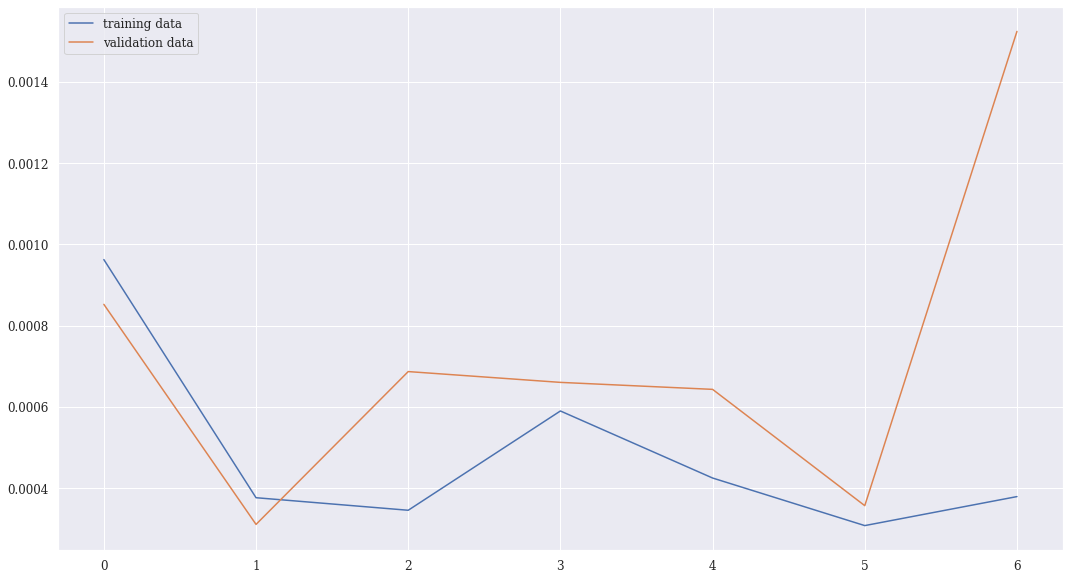

In [66]:
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# current_path is the default path of the os.getcwd()
cp = tf.keras.callbacks.ModelCheckpoint(current_path, monitor='val_loss', save_best_only=True)
history4 = model4.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es, cp])
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.legend()
plt.show()

Actual training data has length (783,)
Predicted training data has length 754 (754, 1)


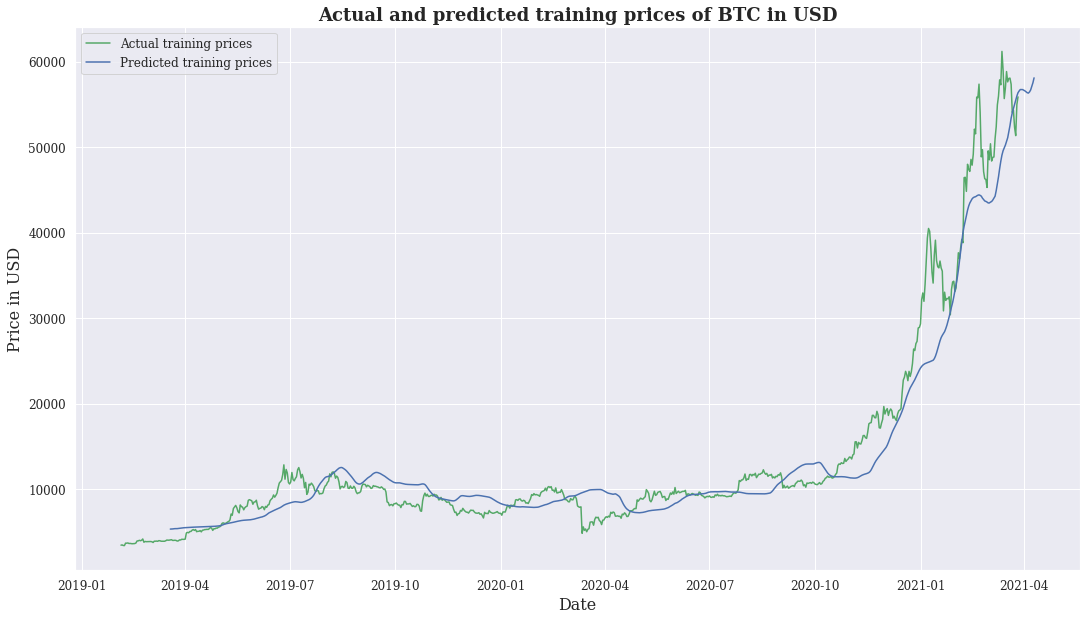

In [67]:
# Predict with training data
BTC_y_pred = model4.predict(train_generator)

# Inverse transform the data back
BTC_y_pred_prices = scaler_y_2019.inverse_transform(BTC_y_pred)
print('Actual training data has length', BTC_2019_y[:index_70pct].shape)
print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
# print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[13:index_70pct]))

plt.plot(BTC_2019_y[:index_70pct].index, BTC_2019_y[:index_70pct].values, color = 'g', label = 'Actual training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_2019_y[43:index_70pct+14].index, BTC_y_pred_prices, color = 'b', label = 'Predicted training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

Number of missing data points in each column is actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64


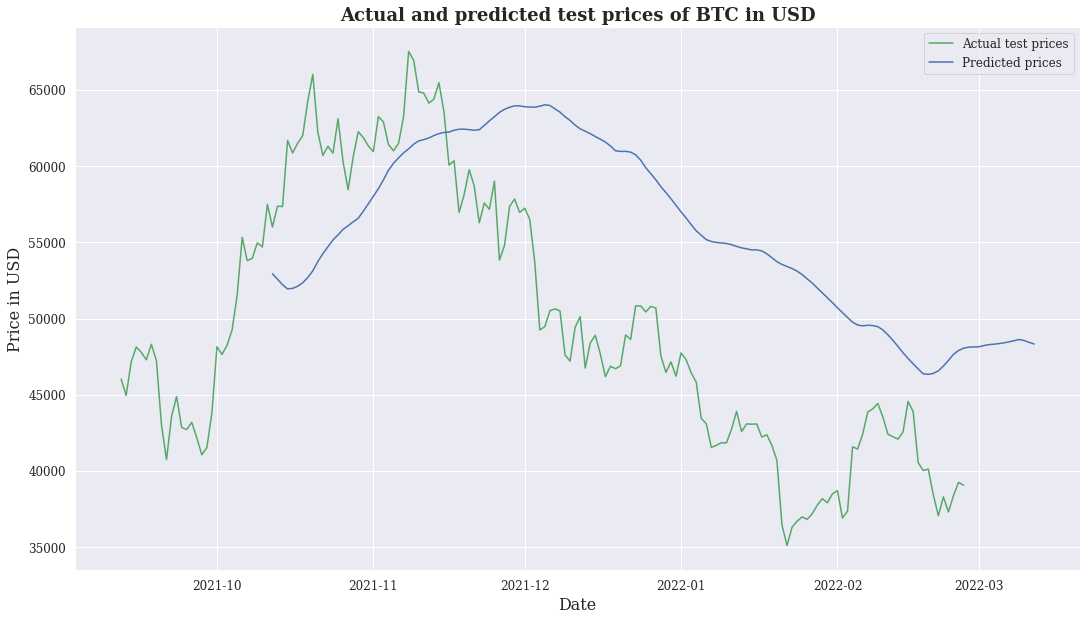

In [68]:
def predict_put_results_in_df_and_plot_2019(model, generator_set):
  # Actual prices from the data
  df_actual = pd.DataFrame({'actual_price':  BTC_2019_y[index_85pct:].values, 'date': BTC_2019_y[index_85pct:].index})
  
  # Predicted prices from the given generator set
  BTC_y_pred = model.predict(generator_set)
  BTC_y_pred_prices = scaler_y_2019.inverse_transform(BTC_y_pred)
  days_in_sample_pred = BTC_2019_y[index_85pct+30:].index
  # print(days_in_sample_pred)
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': BTC_y_pred_prices.reshape(len(BTC_y_pred_prices)), 'date': days_in_sample_pred})

  # Get the extra days for future predicted prices
  days_future_pred = BTC_2019_y[-14:].index + timedelta(14)
  # Get the last 30 days of X, and it'll predict close of 14 days later
  scaled_BTC_day_2019 = scaler_X_2019.transform(BTC_day_2019)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_BTC_day_2019[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y_2019.inverse_transform(y_pred)
  # Get the dates for the future preds
  days_plot_new_pred = BTC_2019_y[-14:].index + timedelta(14)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print('Number of missing data points in each column is', df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

df_plot = predict_put_results_in_df_and_plot_2019(model4, test_generator)
plt.plot(df_plot['actual_price'], color = 'g', label = 'Actual test prices')
plt.plot(df_plot['pred_future_price'], color = 'b', label = 'Predicted prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()

In [69]:
# Price prediction of future 14 days
df_plot.tail(14)

,actual_price,pred_in_sample_price,pred_future_price
date,,,
2022-02-27,NaN,NaN,48121.964844
2022-02-28,NaN,NaN,48139.582031
2022-03-01,NaN,NaN,48144.234375
2022-03-02,NaN,NaN,48227.753906
2022-03-03,NaN,NaN,48288.640625
2022-03-04,NaN,NaN,48316.437500
2022-03-05,NaN,NaN,48356.800781
2022-03-06,NaN,NaN,48407.144531
2022-03-07,NaN,NaN,48471.308594


Actual test data has length (168,)
Predicted test data has length 138 (138, 1)
The test MSE is 98800675.98784494


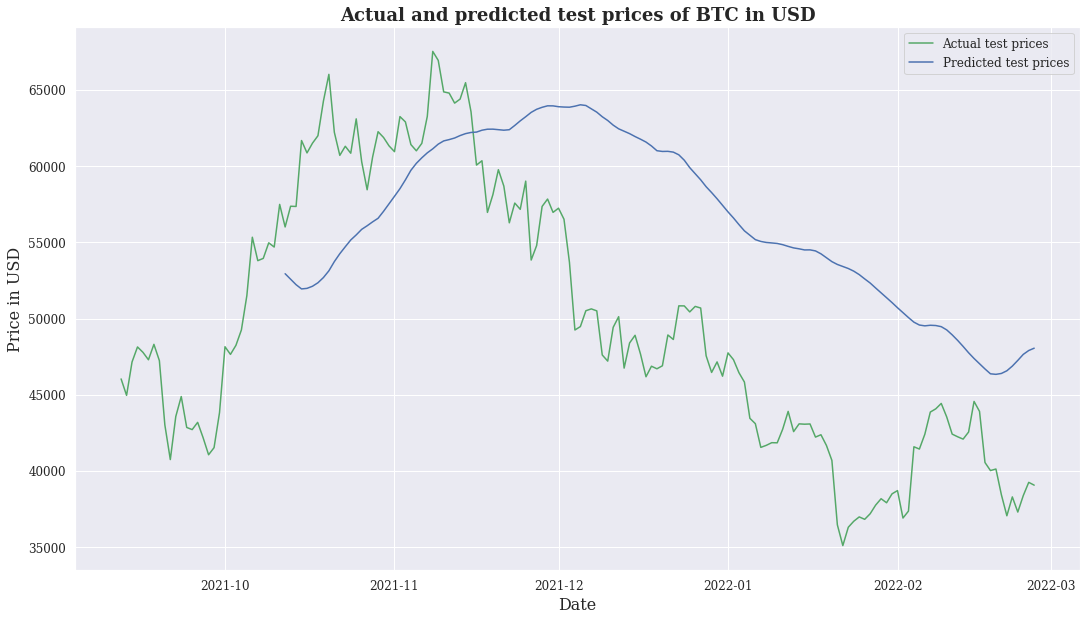

MlflowException: INVALID_PARAMETER_VALUE: Changing param value is not allowed. Param with key='Number of neurons' was already logged with value='[128, 64, 64, 0.1, 1]' for run ID='1cc752d4a6df483b8f7665f9286ff125. Attempted logging new value '[128, 64, 64, 0.2, 1]'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an MlflowException for overwriting a
logged parameter.

Correct Example:
---------------------------------------
with mlflow.start_run():
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 3)
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 5)
---------------------------------------

Which will create a new nested run for each individual
model and prevent parameter key collisions within the
tracking store.'

In [70]:
# Predict with test data
BTC_y_pred_test = model4.predict(test_generator)
# print(BTC_y_pred_test)

# Inverse transform the data back
BTC_y_pred_test_prices = scaler_y_2019.inverse_transform(BTC_y_pred_test)
print('Actual test data has length', BTC_2019_y[index_85pct:].shape)
print('Predicted test data has length', len(BTC_y_pred_test_prices), BTC_y_pred_test_prices.shape)
print('The test MSE is', mean_squared_error(BTC_y_pred_test_prices, BTC_2019_y[index_85pct+30:]))

plt.plot(BTC_2019_y[index_85pct:].index, BTC_2019_y[index_85pct:].values, color = 'g', label = 'Actual test prices')
# Shift index by 30 days forward for predicted prices to get the right dates
plt.plot(BTC_2019_y[index_85pct+30:].index, BTC_y_pred_test_prices, color = 'b', label = 'Predicted test prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()
# Track and log the experiment's metrics and params
client.log_metric(run.info.run_id, "mse", mean_squared_error(BTC_y_pred_test_prices, BTC_2019_y[index_85pct+30:]))
client.log_metric(run.info.run_id, "mae", mean_absolute_error(BTC_y_pred_test_prices, BTC_2019_y[index_85pct+30:]))
client.log_param(run.info.run_id, "model", 'LSTM model with Time Series Generator with 2020+ data')
client.log_param(run.info.run_id, "Number of neurons", [128, 64, 64, 0.2, 1])
client.log_param(run.info.run_id, "seq_len", 30)
client.log_param(run.info.run_id, "batch_size", 32)

# LSTM model forecasting 'High' with 2020+ data

In [71]:
BTC_since_2020 = BTC['2020-01-01':]
BTC_day_2020 = daily_data(BTC_since_2020)

# Get all the 13 features 
BTC_day_2020 = get_features(BTC_day_2020)
BTC_day_2020

# Using high as a feature
BTC_2020_y_high = BTC_day_2020['high'][14:]  #  Exclude the first 14 days 
BTC_2020_X_high = BTC_day_2020[:-14]  # Exclude the last 14 days, no need to drop 'high' as it'll be a feature also
print('Shape of data since 2019 for BTC is', BTC_2020_X_high.shape, BTC_2020_y_high.shape)

scaler_X_2020_high = MinMaxScaler()
BTC_2020_X_scaled_high = scaler_X_2020_high.fit_transform(BTC_2020_X)

scaler_y_2020_high = MinMaxScaler()
values_BTC_2020_y_high = BTC_2020_y_high.values.reshape(-1, 1)
BTC_2020_y_scaled_high = scaler_y_2020_high.fit_transform(values_BTC_2020_y_high) 
print('Shape of BTC data after scaled is', BTC_2020_X_scaled_high.shape, BTC_2020_y_scaled_high.shape)

# Set the index to divide data into train, val, and test sets
index_70pct = int(len(BTC_2020_X)*0.7) # end of training set
index_85pct = int(len(BTC_2020_X)*0.85) # end of val set and beginning of test set
print('Length of entire data is', len(BTC_2020_X))
print('The ending index for training set is', index_70pct)
print('The beginning index for test set (also the ending index for val set) is', index_85pct)

Shape of data since 2019 for BTC is (754, 13) (754,)
Shape of BTC data after scaled is (754, 13) (754, 1)
Length of entire data is 754
The ending index for training set is 527
The beginning index for test set (also the ending index for val set) is 640


In [72]:
# Define time series generator
seq_len = 30 # Length of each sequence
batch_size = 32 # Number of observations
n_features = 13

train_generator = TimeseriesGenerator(BTC_2020_X_scaled_high, BTC_2020_y_scaled_high, length=seq_len, batch_size=batch_size, end_index = index_70pct)
val_generator = TimeseriesGenerator(BTC_2020_X_scaled_high, BTC_2020_y_scaled_high, length=seq_len, batch_size=batch_size, \
                                    start_index = index_70pct, end_index = index_85pct)
test_generator = TimeseriesGenerator(BTC_2020_X_scaled_high, BTC_2020_y_scaled_high, length=seq_len, batch_size=batch_size, start_index = index_85pct)

In [73]:
# Best model so far with 2020+ data and test MSE of 14,786,877
# Best 2021+ data has test MSE of 21,831,109
def init_model():
    model = Sequential()
    model.add(LSTM(name='lstm_1st_layer', units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
    model.add(LSTM(name='lstm_2nd_layer', units=64, activation='tanh'))
    model.add(Dense(units=64, name='dense_1st_layer', activation = 'LeakyReLU'))
    model.add(Dropout(0.2, name='dropout_layer',))
    model.add(Dense(1, name='final_layer', activation='linear'))
    return model

def compile_model(model): 
    Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mse', 
        optimizer = Adam_opt,
        metrics='mse')
    return model

model5 = init_model()
compile_model(model5)
model5.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1st_layer (LSTM)       (None, 30, 128)           72704     
                                                                 
 lstm_2nd_layer (LSTM)       (None, 64)                49408     
                                                                 
 dense_1st_layer (Dense)     (None, 64)                4160      
                                                                 
 dropout_layer (Dropout)     (None, 64)                0         
                                                                 
 final_layer (Dense)         (None, 1)                 65        
                                                                 
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0769 - mse: 0.0769

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 7s 287ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0836 - val_mse: 0.0836
Epoch 3/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0281 - mse: 0.0281

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 4s 275ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 4/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0147 - mse: 0.0147  

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 4s 259ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 5/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 6/50
16/16 [==============================] - 1s 33ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 7/50
16/16 [==============================] - 1s 33ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 8/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0124 - mse: 0.0124  

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 5s 299ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 9/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 10/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0104 - mse: 0.0104

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 4s 257ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 11/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0150 - mse: 0.0150

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 4s 255ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 12/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 13/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 14/50
16/16 [==============================] - 1s 32ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 15/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0098 - mse: 0.0098

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 4s 285ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 16/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0103 - mse: 0.0103

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 4s 258ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 17/50
15/16 [===========================>..] - ETA: 0s - loss: 0.0090 - mse: 0.0090

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


16/16 [==============================] - 5s 305ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 18/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 19/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 20/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 21/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 22/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 23/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 24/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0074 - mse:

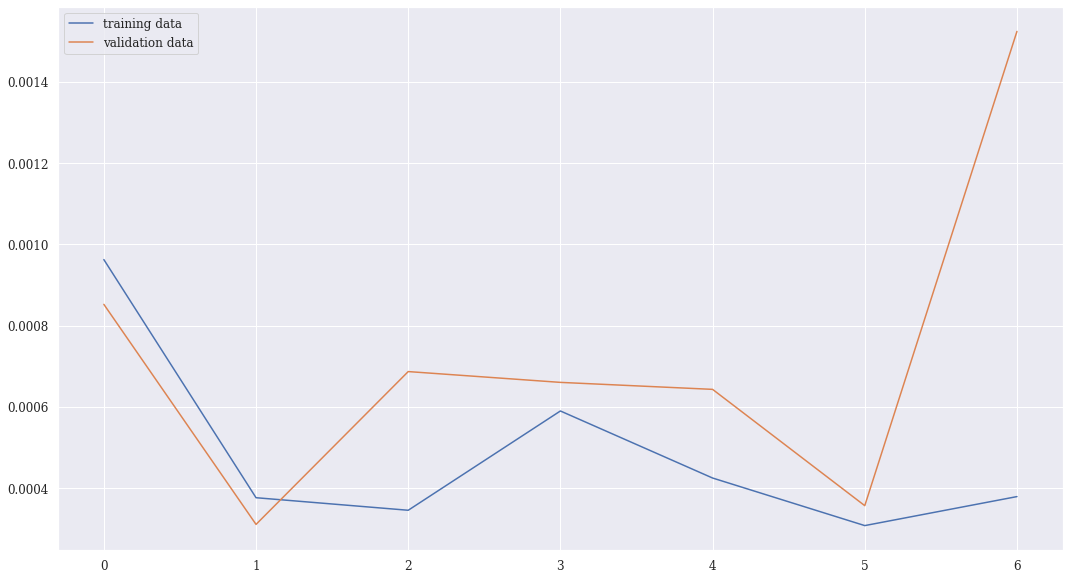

In [74]:
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# current_path is the default path of the os.getcwd()
cp = tf.keras.callbacks.ModelCheckpoint(f'{current_path}/checkpoints', monitor='val_loss', save_best_only=True)
history5 = model5.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es, cp])
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.legend()
plt.show()

Actual training data has length (527,)
Predicted training data has length 498 (498, 1)


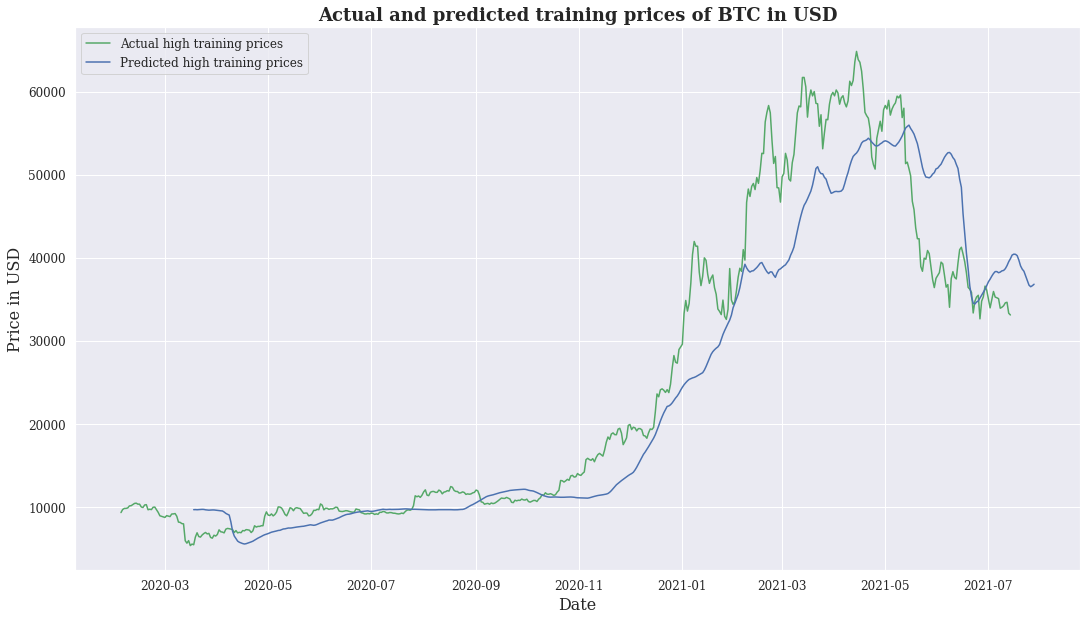

In [75]:
# Predict with training data
BTC_y_pred = model5.predict(train_generator)

# Inverse transform the data back
BTC_y_pred_prices = scaler_y_2020_high.inverse_transform(BTC_y_pred)
print('Actual training data has length', BTC_2020_y_high[:index_70pct].shape)
print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
# print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[13:index_70pct]))

plt.plot(BTC_2020_y_high[:index_70pct].index, BTC_2020_y_high[:index_70pct].values, color = 'g', label = 'Actual high training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_2020_y_high[43:index_70pct+14].index, BTC_y_pred_prices, color = 'b', label = 'Predicted high training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

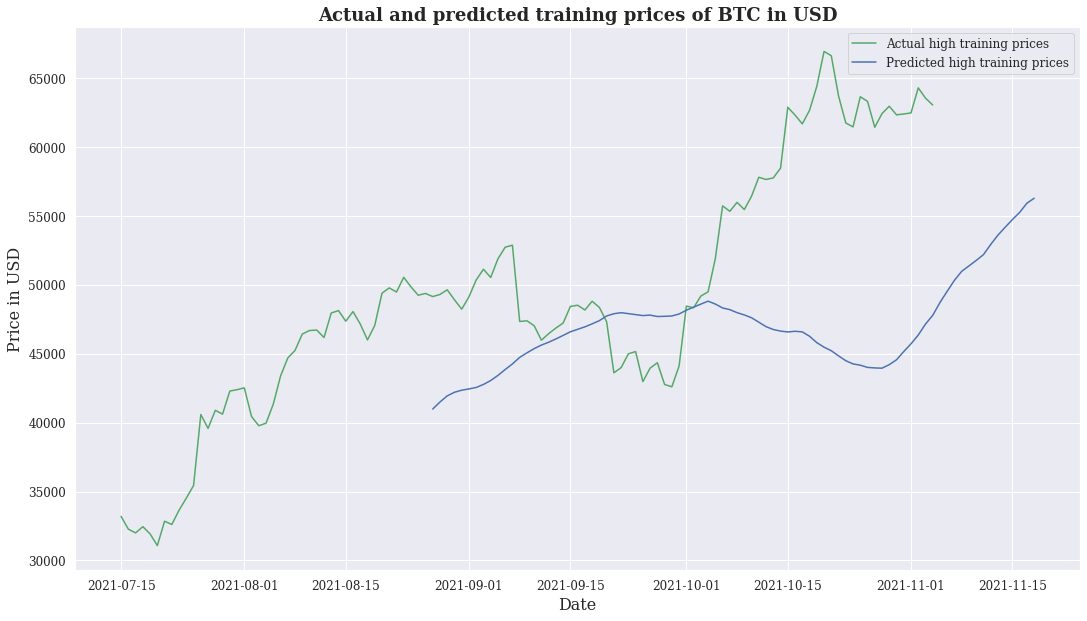

In [76]:
# Predict with val data
BTC_y_pred_val = model5.predict(val_generator)

# Inverse transform the data back
BTC_y_pred_prices_val = scaler_y_2020_high.inverse_transform(BTC_y_pred_val)
# print('Actual training data has length', BTC_2020_y_high[:index_70pct].shape)
# print('Predicted training data has length', len(BTC_y_pred_prices), BTC_y_pred_prices.shape)
# print('The MSE is', mean_squared_error(BTC_y_pred_prices, BTC_day_y[13:index_70pct]))

plt.plot(BTC_2020_y_high[index_70pct:index_85pct].index, BTC_2020_y_high[index_70pct:index_85pct].values, color = 'g', label = 'Actual high training prices')
# Shift index by 30 days forward for predicted prices
plt.plot(BTC_2020_y_high[index_70pct+43:index_85pct+14].index, BTC_y_pred_prices_val, color = 'b', label = 'Predicted high training prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted training prices of BTC in USD')
plt.show()

actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64
Number of missing data points in each column is actual_price            14
date                     0
pred_in_sample_price    44
pred_future_price       30
dtype: int64


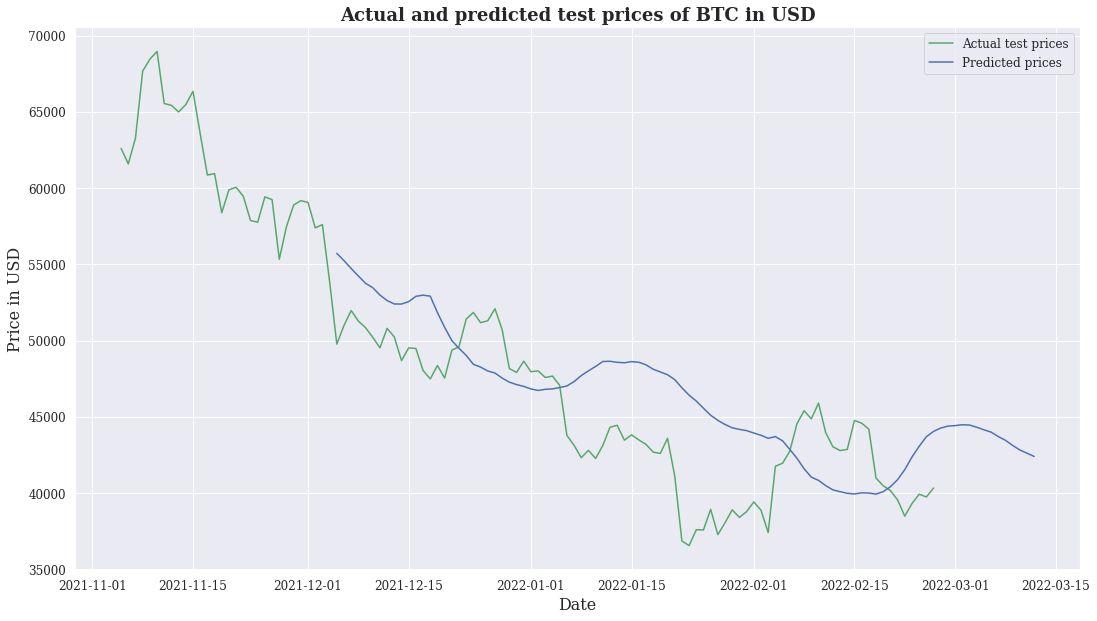

In [77]:
def predict_put_results_in_df_and_plot_2020_high(model, generator_set):
  # Actual prices from the data
  df_actual = pd.DataFrame({'actual_price':  BTC_2020_y_high[index_85pct:].values, 'date': BTC_2020_y_high[index_85pct:].index})
  
  # Predicted prices from the given generator set
  BTC_y_pred = model.predict(generator_set)
  BTC_y_pred_prices = scaler_y_2020_high.inverse_transform(BTC_y_pred)
  days_in_sample_pred = BTC_2020_y_high[index_85pct+30:].index
  # print(days_in_sample_pred)
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': BTC_y_pred_prices.reshape(len(BTC_y_pred_prices)), 'date': days_in_sample_pred})

  # Get the extra days for future predicted prices
  days_future_pred = BTC_2020_y_high[-14:].index + timedelta(14)
  # Get the last 30 days of X, and it'll predict close of 14 days later
  scaled_BTC_day_2020 = scaler_X_2020_high.transform(BTC_day_2020)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_BTC_day_2020[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y_2020_high.inverse_transform(y_pred)
  # Get the dates for the future preds
  days_plot_new_pred = BTC_2020_y_high[-14:].index + timedelta(14)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_plot_new_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print('Number of missing data points in each column is', df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

df_plot_close = predict_put_results_in_df_and_plot_2020(model2, test_generator)
df_plot = predict_put_results_in_df_and_plot_2020_high(model5, test_generator)
plt.plot(df_plot['actual_price'], color = 'g', label = 'Actual test prices')
plt.plot(df_plot['pred_future_price'], color = 'b', label = 'Predicted prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()

In [78]:
# Price prediction of future 14 days
df_plot.tail(14)

,actual_price,pred_in_sample_price,pred_future_price
date,,,
2022-02-27,NaN,NaN,44265.261719
2022-02-28,NaN,NaN,44388.375000
2022-03-01,NaN,NaN,44422.578125
2022-03-02,NaN,NaN,44479.742188
2022-03-03,NaN,NaN,44459.910156
2022-03-04,NaN,NaN,44317.714844
2022-03-05,NaN,NaN,44150.691406
2022-03-06,NaN,NaN,43997.000000
2022-03-07,NaN,NaN,43706.835938


Actual test data has length (114,)
Predicted test data has length 84 (84, 1)
The test MSE is 18608040.92959258


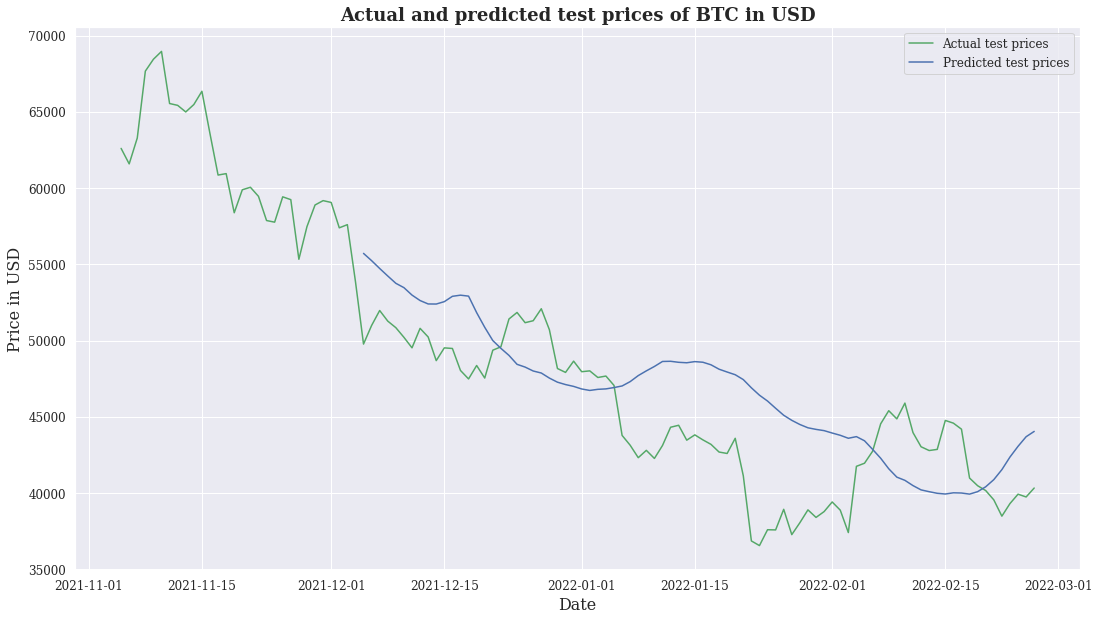

MlflowException: INVALID_PARAMETER_VALUE: Changing param value is not allowed. Param with key='Number of neurons' was already logged with value='[128, 64, 64, 0.1, 1]' for run ID='1cc752d4a6df483b8f7665f9286ff125. Attempted logging new value '[128, 64, 64, 0.2, 1]'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an MlflowException for overwriting a
logged parameter.

Correct Example:
---------------------------------------
with mlflow.start_run():
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 3)
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 5)
---------------------------------------

Which will create a new nested run for each individual
model and prevent parameter key collisions within the
tracking store.'

In [79]:
# Predict with test data
BTC_y_pred_test = model5.predict(test_generator)
# print(BTC_y_pred_test)

# Inverse transform the data back
BTC_y_pred_test_prices = scaler_y_2020_high.inverse_transform(BTC_y_pred_test)
print('Actual test data has length', BTC_2020_y_high[index_85pct:].shape)
print('Predicted test data has length', len(BTC_y_pred_test_prices), BTC_y_pred_test_prices.shape)
print('The test MSE is', mean_squared_error(BTC_y_pred_test_prices, BTC_2020_y_high[index_85pct+30:]))

plt.plot(BTC_2020_y_high[index_85pct:].index, BTC_2020_y_high[index_85pct:].values, color = 'g', label = 'Actual test prices')
# Shift index by 30 days forward for predicted prices to get the right dates
plt.plot(BTC_2020_y_high[index_85pct+30:].index, BTC_y_pred_test_prices, color = 'b', label = 'Predicted test prices')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Actual and predicted test prices of BTC in USD')
plt.show()
# Track and log the experiment's metrics and params
client.log_metric(run.info.run_id, "mse", mean_squared_error(BTC_y_pred_test_prices, BTC_2020_y_high[index_85pct+30:]))
client.log_metric(run.info.run_id, "mae", mean_absolute_error(BTC_y_pred_test_prices, BTC_2020_y_high[index_85pct+30:]))
client.log_param(run.info.run_id, "model", 'LSTM model with Time Series Generator with 2020+ data')
client.log_param(run.info.run_id, "Number of neurons", [128, 64, 64, 0.2, 1])
client.log_param(run.info.run_id, "seq_len", 30)
client.log_param(run.info.run_id, "batch_size", 32)

# Packaging things together into API

## Required functions

In [80]:
def get_data(crypto, last_rows=1_000_000):
    """ Get dataset of selected crypto from cloud storage
    1,000,000 data points (mins) is roughly equivalent to 2 years worth of data
    # Params: chosen crypto by the user from the front end """
    df = None
    if crypto == "BTC":
        df_full = pd.read_csv(BTC_USD_URL)
        n_rows = len(df_full)
        df = pd.read_csv(BTC_USD_URL, skiprows=range(1, n_rows - last_rows))
    elif crypto == 'ETH':
        df_full = pd.read_csv(ETH_USD_URL)
        n_rows = len(df_full)
        df = pd.read_csv(ETH_USD_URL, skiprows=range(1, n_rows - last_rows))
    elif crypto == 'LTC':
        df_full = pd.read_csv(LTC_USD_S3URI)
        n_rows = len(df_full)
        df = pd.read_csv(LTC_USD_S3URI, skiprows=range(1, n_rows - last_rows))
    else:
        print('No such crypto pair or file exists, please check')
    return df

def organize_data(df):
    """Returns a dataframe with time in human-readable time as the index"""
    df.time = pd.to_datetime(df.time, unit='ms')
    df_t = df.set_index('time')
    return df_t

## The 3 predict functions

In [81]:
# Variables to change
crypto = 'ETH'
forecast_objective = 'low'
seq_len = 30
batch_size = 32

In [83]:
def get_LSTM_data_with_objective(crypto, forecast_objective):
  """ User will pass in the crypto name and the corresponding objective: 'close', 'high', 'low', 'open', and the dataset
  for use with LSTM model will be generated 
  Returns: X and y"""
  df = get_data(crypto)
  df = organize_data(df)
  # Slice data if we happen to have data older than 2020 so that we only use data from the beginning of 2020
  cutoff_date = datetime.strptime('2020-01-01', '%Y-%M-%d')
  if df.index[0] < cutoff_date:
    df = df[cutoff_date:]
  df = daily_data(df)
  df = get_features(df)
  y = df[forecast_objective][14:] # Target, exclude the first 14 days 
  X = df[:-14]  # Exclude the last 14 days, all columns will be used as features
  return X, y

def preprocessing_LSTM_data_and_get_generators(X, y):
  """ Preprocessing data with MinMax scaler and return the 3 generators, the 2 index percentiles
  for val and test sets, and the respective X & y scalers to be used with prediction. 
  Params: X (features dataset) and y (target) """
  scaler_X = MinMaxScaler()
  X_scaled = scaler_X.fit_transform(X)

  scaler_y = MinMaxScaler()
  values_y = y.values.reshape(-1, 1)
  y_scaled = scaler_y.fit_transform(values_y) 
  print('Shape of data after scaled is', X_scaled.shape, y_scaled.shape)

  # Set the index to divide data into train, val, and test sets
  index_70pct = int(len(X)*0.7) # end of training set
  index_85pct = int(len(X)*0.85) # end of val set and beginning of test set
  print('The ending index for training set is', index_70pct)
  print('The beginning index for test set (also the ending index for val set) is', index_85pct)

  # Define time series generator for training, validation, and test sets
  seq_len = 30 # Length of each sequence
  batch_size = 32 # Number of observations
  n_features = X_scaled.shape[1]

  train_generator = TimeseriesGenerator(X_scaled, y_scaled, length=seq_len, batch_size=batch_size, end_index = index_70pct)
  val_generator = TimeseriesGenerator(X_scaled, y_scaled, length=seq_len, batch_size=batch_size, \
                                      start_index = index_70pct, end_index = index_85pct)
  test_generator = TimeseriesGenerator(X_scaled, y_scaled, length=seq_len, batch_size=batch_size, start_index = index_85pct)
  return train_generator, val_generator, test_generator, index_70pct, index_85pct, scaler_X, scaler_y
  
def init_and_compile_model(X):
  """ Initialize and compile the LSTM model with Adam optimizer"""
  n_features = X.shape[1]
  model = Sequential()
  model.add(LSTM(name='lstm_1st_layer', units=128, return_sequences=True, activation='relu', input_shape=(seq_len, n_features)))
  model.add(LSTM(name='lstm_2nd_layer', units=64, activation='tanh'))
  model.add(Dense(units=64, name='dense_1st_layer', activation = 'LeakyReLU'))
  model.add(Dropout(0.2, name='dropout_layer',))
  model.add(Dense(1, name='final_layer', activation='linear'))
  Adam_opt = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='mse', optimizer = Adam_opt, metrics='mse')
  return model

def fit_LSTM_model(model, train_generator, val_generator):
  """ Fit an LSTM model with training data and validate on validation data"""
  current_path = os.getcwd() # current directory
  # Run and fit the model
  es = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
  cp = tf.keras.callbacks.ModelCheckpoint(f'{current_path}/checkpoints', monitor='val_loss', save_best_only=True)
  history = model.fit(train_generator, validation_data = val_generator, epochs=50, verbose=1, callbacks=[es, cp])
  plt.plot(history.history['loss'], label='training data')
  plt.plot(history.history['val_loss'], label='validation data')
  plt.legend()
  plt.show()
  return model

def LSTM_predict_with_generator(model, X, y, scaler_X, scaler_y, index_70pct, index_85pct, test_generator):
  """ Pass in the model, the original X and y data, along with the 70%, 85% and the test generator in order to 
  predict the future 14 days with the LSTM model and return the entire historical and predicted data as 1 df"""
  # Actual prices from the entire data
  df_actual = pd.DataFrame({'actual_price':  y.values, 'date': y.index})
  
  # Predicted prices from the given generator set
  y_in_sample_pred = model.predict(test_generator)
  y_in_sample_pred_prices = scaler_y.inverse_transform(y_in_sample_pred)
  days_in_sample_pred = y[index_85pct+30:].index
  # print(days_in_sample_pred)
  # print(len(BTC_y_pred_prices), len(days_in_sample_pred))
  df_pred_in_sample = pd.DataFrame({'pred_in_sample_price': y_in_sample_pred_prices.reshape(len(y_in_sample_pred_prices)), \
                                    'date': days_in_sample_pred})

  # Get the last 30 days of X, and it'll predict the forecast objective of 14 days later
  scaled_X = scaler_X.transform(X)
  seq_X = []
  for i in range(14):
    seq_X.append(scaled_X[-44+i:-14+i])
  seq_X = np.array(seq_X)
  # Predict the future 14 days from the last 44-day values
  y_pred = model.predict(seq_X)
  y_pred_prices = scaler_y.inverse_transform(y_pred)
  # Get the values of the extra days for future predicted prices
  days_future_pred = y[-14:].index + timedelta(14)
  y_pred_df = pd.DataFrame({'pred_future_price': y_pred_prices.reshape(14,), 'date': days_future_pred})
  y_pred_df.set_index('date', inplace=True)

  df_plot = df_actual.merge(df_pred_in_sample, how='outer', on='date').merge(y_pred_df, how='outer', on='date')
  df_plot['pred_future_price'].fillna(df_plot['pred_in_sample_price'], inplace=True)
  print('Number of missing data points in each column is', df_plot.isnull().sum())
  df_plot.set_index('date', inplace=True)
  return df_plot

def plot_LSTM_final_results(df_plot, crypto):
  """ Plot the final results with actual prices and predicted prices (from test generator) for given crypto """
  plt.plot(df_plot['actual_price'], color = 'g', label = f'Actual prices of {crypto}')
  plt.plot(df_plot['pred_future_price'], color = 'b', label = f'Predicted prices of {crypto}')
  plt.legend(loc='best')
  plt.xlabel('Date')
  plt.ylabel('Price in USD')
  plt.title(f'Actual and predicted prices of {crypto} in USD')
  plt.show()

Shape of data after scaled is (698, 13) (698, 1)
The ending index for training set is 488
The beginning index for test set (also the ending index for val set) is 593
Epoch 1/50
14/15 [===========================>..] - ETA: 0s - loss: 0.0447 - mse: 0.0447

INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


INFO:tensorflow:Assets written to: /home/user/PycharmProjects/crypto_backend/notebooks/checkpoints/assets


15/15 [==============================] - 7s 349ms/step - loss: 0.0427 - mse: 0.0427 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 2/50
15/15 [==============================] - 1s 34ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 3/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 4/50
15/15 [==============================] - 0s 32ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0626 - val_mse: 0.0626
Epoch 5/50
15/15 [==============================] - 1s 34ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 6/50
15/15 [==============================] - 1s 34ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 7/50
15/15 [==============================] - 1s 35ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 8/50
15/15 [==============================] - 1s 33ms/step - loss: 0.0051 - mse: 0.0051

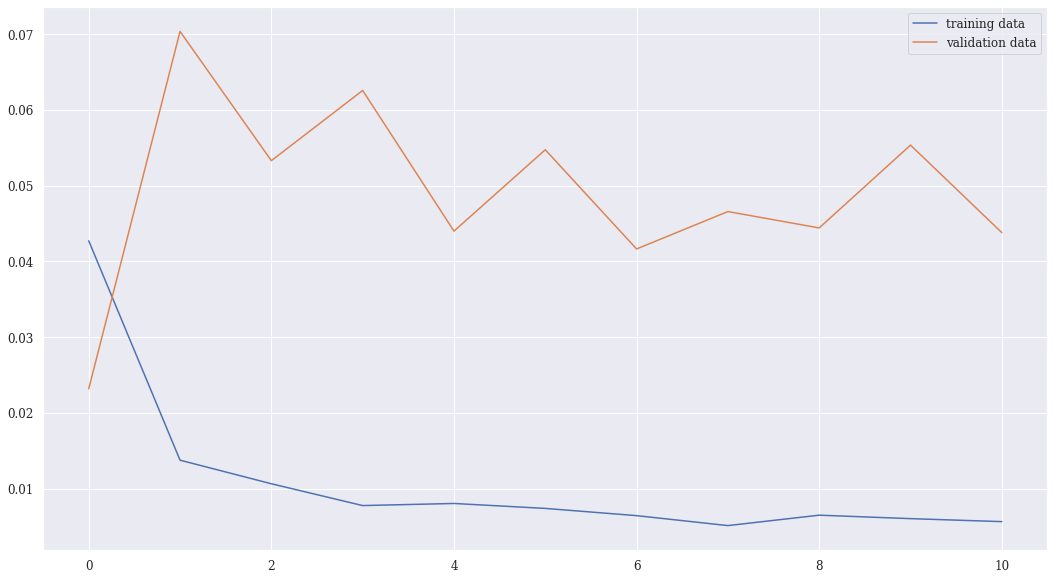

Number of missing data points in each column is actual_price             14
date                      0
pred_in_sample_price    637
pred_future_price       623
dtype: int64


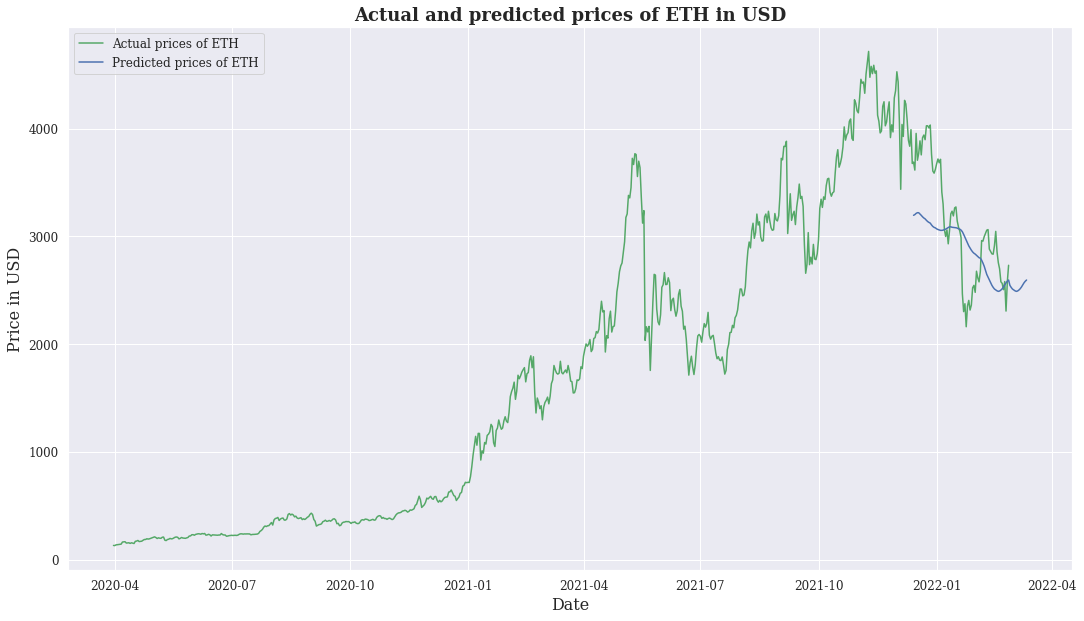

In [84]:
# For testing and saving model
X, y = get_LSTM_data_with_objective(crypto, forecast_objective)
train_gen, val_gen, test_gen, index_70pct, index_85pct, scaler_X, scaler_y = preprocessing_LSTM_data_and_get_generators(X, y)
model = init_and_compile_model(X)
model = fit_LSTM_model(model, train_gen, val_gen)
df_plot = LSTM_predict_with_generator(model, X, y, scaler_X, scaler_y, index_70pct, index_85pct, test_gen)
plot_LSTM_final_results(df_plot, crypto)

In [85]:
df_plot

,actual_price,pred_in_sample_price,pred_future_price
date,,,
2020-03-31,130.63,NaN,NaN
2020-04-01,129.22,NaN,NaN
2020-04-02,135.85,NaN,NaN
2020-04-03,138.01,NaN,NaN
2020-04-04,139.17,NaN,NaN
...,...,...,...
2022-03-08,NaN,NaN,2528.970459
2022-03-09,NaN,NaN,2548.110596
2022-03-10,NaN,NaN,2568.192871


In [86]:
os.getcwd()

'/home/user/PycharmProjects/crypto_backend/notebooks'

In [87]:
# Save model to the current folder 
model.save(f'{crypto}_LSTM_{forecast_objective}_model')
# zip
!zip -r ETH_LSTM_low_model.zip ETH_LSTM_low_model
# download
files.download(f'{crypto}_LSTM_{forecast_objective}_model.zip')

INFO:tensorflow:Assets written to: ETH_LSTM_low_model/assets


INFO:tensorflow:Assets written to: ETH_LSTM_low_model/assets


  adding: ETH_LSTM_low_model/ (stored 0%)
  adding: ETH_LSTM_low_model/saved_model.pb (deflated 90%)
  adding: ETH_LSTM_low_model/assets/ (stored 0%)
  adding: ETH_LSTM_low_model/keras_metadata.pb (deflated 90%)
  adding: ETH_LSTM_low_model/variables/ (stored 0%)
  adding: ETH_LSTM_low_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: ETH_LSTM_low_model/variables/variables.index (deflated 66%)


NameError: name 'files' is not defined

In [88]:
# Load model
loaded_model = tf.keras.models.load_model(f'{crypto}_LSTM_{forecast_objective}_model')
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1st_layer (LSTM)       (None, 30, 128)           72704     
                                                                 
 lstm_2nd_layer (LSTM)       (None, 64)                49408     
                                                                 
 dense_1st_layer (Dense)     (None, 64)                4160      
                                                                 
 dropout_layer (Dropout)     (None, 64)                0         
                                                                 
 final_layer (Dense)         (None, 1)                 65        
                                                                 
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Retest loading just .pb file 